<div style="background-color: #0926A0; text-align: center; ">
<h1 style="margin: auto; padding: 50px; color:#fff; ">Organisation nationale de lutte contre le
faux-monnayage (ONCFM)</h1>
</div>


<div style="background-color: #002FD0; width: 100%;" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Contexte et champ méthodologique</h2>
</div>

L’Organisation nationale de lutte contre le faux-monnayage (ONCFM) est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le
cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

**Objectif :**

Lorsqu’un billet arrive, nous avons une machine qui consigne l’ensemble de ses caractéristiques géométriques. Au fil de nos années de lutte, nous avons observé des différences de dimensions entre les vrais et les faux
billets. Ces différences sont difficilement visibles à l’œil nu, mais une machine devrait sans problème arriver à les différencier. Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques
géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

**Modèle de données**

6 informations géométriques sur un billet :
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- diagonal : la diagonale du billet (en mm).

Ces informations sont celles avec lesquelles l’algorithme devra opérer.

Un fichier d’exemple contenant 1 500 billets, que vous pouvez utiliser comme bon vous semble pour paramétrer votre algorithme. Parmi ces 1 500 billets, 1 000 sont vrais et 500 sont faux ; une colonne a été ajoutée pour vous préciser la nature du billet.

**Algorithme**

L’algorithme devra donc être capable de prendre en entrée un fichier contenant les dimensions de plusieurs billets, et de déterminer le type de chacun d’entre eux à partir des seules dimensions. Nous fournissons à ce sujet le format type de nos fichiers de billets avec lequel l’algorithme sera censé fonctionner, au sein d’un fichier nommé billets_production.csv. Nous aimerions pouvoir mettre en concurrence quatre méthodes de
prédiction :
- une régression logistique classique ;
- un k-means, duquel seront utilisés les centroïdes pour réaliser la
prédiction ;
- un KNN ;
- un random forest.

Pour une évaluation optimale des modèles, nous souhaitons avoir une analyse des nombres de faux positifs et faux négatifs via une matrice de confusion.

<h2 style="margin: auto; padding: 20px; color:#000000; ">Etape 1 - Importation des librairies et chargement du fichier</h2>
</div>

In [1]:
# Importation des librairies
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats as st
from scipy.stats import jarque_bera
from tabulate import tabulate
from pathlib import Path
from unidecode import unidecode
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    make_scorer,
    det_curve,
    RocCurveDisplay,
    DetCurveDisplay,
)
from sklearn.metrics.cluster import v_measure_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Binarizer,
    StandardScaler,
    FunctionTransformer,
    label_binarize,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    TunedThresholdClassifierCV,
    learning_curve,
    LearningCurveDisplay,
)
from sklearn.dummy import check_random_state
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import __version__ as sklearn_version

In [2]:
# Afficher les versions des librairies utilisées
print("Pandas :", pd.__version__)
print("Numpy:", np.__version__)
print("Statsmodels :", sm.__version__)
print("Sklearn :", sklearn.__version__)
print("Matplotlib :", matplotlib.__version__)
print("Seaborn :", sns.__version__)

Pandas : 1.4.2
Numpy: 1.21.5
Statsmodels : 0.13.2
Sklearn : 1.6.0
Matplotlib : 3.5.1
Seaborn : 0.11.2


<h3 style="margin: auto; padding: 20px; color: #000000; ">1.1 - Chargements des fichiers</h3>
</div>

In [3]:
# Afficher toutes les colonnes d'un dataframe
pd.set_option("display.max_columns", None)

In [4]:
# Changement de dossier
os.chdir(
    r"C:\Users\jerem\OneDrive\EMPLOI\PôleEmploi\Formation\Data Analyst\Openclassroom\Mes projets\Projet 12\oncfm"
)

# Chargement des données
try:
    df_faux_billets = pd.read_csv("billets.csv", sep=";")
    print("Données chargées avec succès.")
    print(
        f"Le DataFrame contient {df_faux_billets.shape[0]} lignes et {df_faux_billets.shape[1]} colonnes."
    )
except FileNotFoundError:
    print(
        "Erreur : le fichier 'billets.csv' est introuvable dans le répertoire actuel."
    )
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement des données : {e}")

Données chargées avec succès.
Le DataFrame contient 1500 lignes et 7 colonnes.


<h3 style="margin: auto; padding: 20px; color: #000000; ">1.2 - Chargements des fonctions</h3>
</div>

In [5]:
def summarize_data(df):
    """
    Résume les informations principales d'un DataFrame, y compris les types de colonnes,
    les valeurs uniques, les valeurs manquantes et leur pourcentage.

    Paramètres :
    ----------
    df : pandas.DataFrame
        Le DataFrame dont on souhaite résumer les informations.

    Retours :
    -------
    pandas.DataFrame
        Un DataFrame contenant les informations suivantes pour chaque colonne :
        - type : Le type de la colonne.
        - total : Nombre total de lignes dans le DataFrame.
        - n : Nombre de valeurs non manquantes par colonne.
        - unique : Nombre de valeurs uniques par colonne.
        - NaN : Nombre de valeurs manquantes par colonne.
        - pourcentage_(NaN) : Pourcentage de valeurs manquantes par colonne (arrondi à 2 décimales).

    Notes :
    ------
    - Le DataFrame de sortie est trié par le pourcentage de valeurs manquantes (ordre décroissant).
    - La fonction affiche également un résumé général du jeu de données :
      nombre de lignes et de colonnes.
    """

    # Afficher le type de la variable
    type_variable = df.dtypes

    # Nombre de lignes totales
    nb_lignes = len(df.index)

    # Nombre total de valeurs dans chaque colonne
    total_values = df.count()

    # Nombre de valeurs uniques dans chaque colonnes
    valeurs_uniques = df.nunique()

    # Calculer le nombre de valeurs manquantes pour chaque colonne
    missing_counts = df.isnull().sum()

    # Calculer le pourcentage de valeurs manquantes pour chaque colonne
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)

    # Créer un DataFrame avec les résultats
    variables_infos = pd.DataFrame(
        {
            "type": type_variable,
            "total": nb_lignes,
            "n": total_values,
            "unique": valeurs_uniques,
            #'doublons' : nb_doublons,
            "NaN": missing_counts,
            "pourcentage_(NaN)": missing_percentage,
        }
    )

    # Trier par 'pourcentage_(NaN)' dans l'ordre décroissant
    variables_infos = variables_infos.sort_values(
        by="pourcentage_(NaN)", ascending=False
    )

    print("Description donnée(s):")
    print("Le jeu de données comporte: {} observation(s)".format(df.shape[0]))
    print("Le jeu de données comporte: {} colonne(s)".format(df.shape[1]))

    return variables_infos

In [6]:
def calculate_descriptive_statistics(data):
    """
    Calcule les statistiques descriptives pour les colonnes numériques d'un DataFrame ou d'une Series pandas.

    Paramètres :
    ----------
    data : pandas.Series ou pandas.DataFrame
        Les données pour lesquelles les statistiques descriptives doivent être calculées.

    Retours :
    -------
    pandas.DataFrame
        Un DataFrame contenant les statistiques descriptives pour chaque colonne numérique :
        - n : Nombre de valeurs non manquantes.
        - unique : Nombre de valeurs uniques.
        - min : Valeur minimale.
        - max : Valeur maximale.
        - moy : Moyenne (moyenne arithmétique).
        - mediane : Médiane (50e percentile).
        - q1 : 1er quartile (25e percentile).
        - iqr : Intervalle interquartile (q3 - q1).
        - q3 : 3e quartile (75e percentile).
        - std : Écart-type.
        - var : Variance.
        - skew : Asymétrie (skewness).
        - kurt : Kurtosis (aplatissement de la distribution).

    Exceptions :
    ----------
    TypeError :
        Levée si l'argument n'est ni une Series ni un DataFrame de pandas.

    Notes :
    ------
    - La fonction ne calcule les statistiques que pour les colonnes numériques.
    - Si une pandas.Series est passée, elle est convertie en DataFrame avant le calcul.
    - La fonction affiche "Statistiques descriptives:" avant de retourner le DataFrame.

    """

    # Vérifier si l'argument est une Series ou un DataFrame
    if isinstance(data, pd.Series):
        df = data.to_frame()
    elif isinstance(data, pd.DataFrame):
        df = data
    else:
        raise TypeError("L'argument doit être une Series ou un DataFrame de pandas")

    # Sélectionner seulement les colonnes numériques
    df_numeric = df.select_dtypes(include="number")

    # Nombre total de valeurs dans chaque colonne
    valeurs_totales = df_numeric.count()

    # Nombre de valeurs uniques dans chaque colonne
    valeurs_uniques = df_numeric.nunique()

    # Valeur minimum dans chaque colonne
    minimum = df_numeric.min()

    # Moyenne dans chaque colonne
    moyenne = df_numeric.mean()

    # 1er quantile dans chaque colonne
    q1 = df_numeric.quantile(0.25)

    # Mediane dans chaque colonne
    mediane = df_numeric.median()

    # 3e quantile dans chaque colonne
    q3 = df_numeric.quantile(0.75)

    # Calcul de l'intervalle interquartile - IQR
    iqr = q3 - q1

    # Valeur maximum dans chaque colonne
    maximum = df_numeric.max()

    # Ecart-type dans chaque colonne
    std = df_numeric.std()

    # Variance dans chaque colonne
    variance = df_numeric.var()

    # Skewness dans chaque colonne
    skewness = df_numeric.skew()

    # Kurtosis dans chaque colonne
    kurtosis = df_numeric.kurtosis()

    # Créer un DataFrame avec les résultats
    stats_descriptives = pd.DataFrame(
        {
            "n": valeurs_totales,
            "unique": valeurs_uniques,
            "min": minimum,
            "max": maximum,
            "moy": moyenne,
            "mediane": mediane,
            "q1": q1,
            "iqr": iqr,
            "q3": q3,
            "std": std,
            "var": variance,
            "skew": skewness,
            "kurt": kurtosis,
        }
    )

    print("Statistiques descriptives:")

    return stats_descriptives

In [7]:
def make_frequency_table(df, column):
    """
    Crée un tableau de fréquence pour une variable catégorielle dans un DataFrame.

    Args:
    - df : DataFrame contenant les données
    - column : Nom de la colonne pour laquelle on souhaite calculer le tableau de fréquence

    Returns:
    - DataFrame : Tableau de fréquence avec fréquences et fréquences cumulées en pourcentage
    """
    # Vérifier si la colonne existe dans le DataFrame
    if column not in df.columns:
        raise ValueError(f"La colonne '{column}' n'existe pas dans le DataFrame.")

    # Calculer les fréquences des modalités
    freq_counts = df[column].value_counts()
    total_count = freq_counts.sum()

    # Créer le tableau de fréquence
    freq_table = pd.DataFrame(
        {"Frequence": freq_counts, "Pourcentage": (freq_counts / total_count) * 100}
    ).reset_index()
    freq_table.columns = [column, "Frequence", "Pourcentage"]

    return freq_table

In [8]:
def visualize_boxplot(
    df, columns, nrows=2, ncols=3, figsize=(15, 8), palette=None, title=None
):
    """

    Trace des boxplots pour les colonnes quantitatives d'un DataFrame dans une grille de subplots.
    Paramètres :

        df (pd.DataFrame) : Le DataFrame contenant les données.
        columns (list) : Liste des colonnes pour lesquelles tracer les boxplots.
        nrows (int) : Nombre de lignes dans la grille de subplots.
        ncols (int) : Nombre de colonnes dans la grille de subplots.
        figsize (tuple) : Dimensions de la figure (largeur, hauteur).
        palette (list) : Liste de couleurs pour personnaliser les boxplots.

    """

    # Palette par défaut si non spécifiée

    if palette is None:

        palette = ["#002fd0", "#c600ab", "#ff117a", "#ff7452", "#ffbb46", "#f9f871"]

    # Création des subplots

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = axes.flatten()  # Aplatir pour un accès facile aux axes

    # Gestion des cas où il y a plus de cases que de colonnes à tracer

    for i, ax in enumerate(axes):

        if i < len(columns):  # Si une colonne existe pour cet axe

            # Assigner une couleur selon la palette (en boucle si nécessaire)

            color = palette[i % len(palette)]

            df.boxplot(
                column=columns[i],
                ax=ax,
                boxprops=dict(color=color),
                whiskerprops=dict(color=color),
                capprops=dict(color=color),
                medianprops=dict(color=color),
            )

            ax.set_title(columns[i])  # Titre correspondant à la colonne

            ax.grid(False)  # Désactiver la grille

        else:  # Si pas de colonne à tracer, cacher l'axe

            ax.axis("off")

            # Ajout d'un titre général
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold")

    # Ajustement des espacements

    plt.tight_layout()

    plt.show()

In [9]:
def visualize_data_distribution(
    df,
    columns,
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    hist_color="#002fd0",
    density_color="#ff117a",
    title=None,
):
    """
    Trace les distributions des variables quantitatives à l'aide d'histogrammes et de courbes de densité.

    Paramètres :
        df (pd.DataFrame) : Le DataFrame contenant les données.
        columns (list) : Liste des colonnes quantitatives à tracer.
        nrows (int) : Nombre de lignes dans la grille de subplots.
        ncols (int) : Nombre de colonnes dans la grille de subplots.
        figsize (tuple) : Dimensions de la figure (largeur, hauteur).
        hist_color (str) : Couleur des histogrammes.
        density_color (str) : Couleur des courbes de densité.
    """
    # Création des subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Aplatir pour un accès facile aux axes

    # Gestion des cas où il y a plus de cases que de colonnes à tracer
    for i, ax in enumerate(axes):
        if i < len(columns):  # Si une colonne existe pour cet axe
            column = columns[i]
            sns.histplot(
                df[column],
                ax=ax,
                kde=True,
                color=hist_color,
                line_kws={"color": density_color},
            )
            ax.set_title(f"Distribution de {column}")
            ax.set_xlabel(column)
            ax.set_ylabel("Fréquence")
        else:  # Si pas de colonne à tracer, cacher l'axe
            ax.axis("off")

            # Ajout d'un titre général
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold")

    # Ajustement des espacements
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_confusion_matrix(y_true, y_pred, labels=None):
    """
    Trace la matrice de confusion à partir des valeurs réelles et prédites.

    Paramètres :
    y_true (array-like) : Vecteur des labels réels.
    y_pred (array-like) : Vecteur des labels prédits.
    labels (list, optionnel) : Liste des labels, s'il y en a, pour nommer les axes.

    Retourne :
    La matrice de confusion sous forme de tableau numpy.
    """
    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Visualisation avec Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Prédictions")
    plt.ylabel("Véritables")
    plt.title("Matrice de Confusion")
    plt.show()

    return cm

In [11]:
def calculate_model_metrics(y_true, y_pred):
    """
    Calcule les métriques de performance pour un modèle de classification et les affiche sous forme de tableau.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes.
    y_pred (array-like) : Les étiquettes prédites par le modèle.

    Retourne :
    None (affiche directement les résultats dans la console).
    """
    # Calcul des métriques
    # Equilibrer l'importance des classes dans mon évaluation (macro avg)
    # Evaluation représentative du jeu de données réel (weighted)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)  # ou 'binary', 'macro', etc.
    precision = precision_score(y_true, y_pred)  # idem ici
    recall = recall_score(y_true, y_pred)  # idem ici
    auc = roc_auc_score(y_true, y_pred)

    # Création du tableau pour tabulate
    metrics = [
        ["Accuracy", accuracy],
        ["F1-score", f1],
        ["Precision", precision],
        ["Recall", recall],
        ["Auc", auc],
    ]

    # Affichage du tableau
    print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="github"))

In [12]:
def visualize_roc_curve(y_true, y_pred_prob, class_names=None):
    """
    Trace la courbe ROC et affiche l'aire sous la courbe (AUC) pour un modèle de classification.

    Paramètres :
    y_true (array-like) : Les vraies étiquettes.
    y_pred_prob (array-like) : Les probabilités prédites par le modèle pour chaque classe.
    class_names (list, optional) : Liste des noms des classes. Si None, les indices de classes seront utilisés.

    Retourne :
    None (affiche directement la courbe ROC).
    """
    # Si y_true est une variable avec plusieurs classes (classification multiclasse)
    if len(y_true.shape) == 1 or y_true.shape[1] == 1:
        # Si c'est un problème binaire, y_pred_prob correspondra à la probabilité pour la classe positive
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        auc = roc_auc_score(y_true, y_pred_prob)
    else:
        # Si c'est un problème multiclasse, on binarise les classes
        y_true_bin = label_binarize(y_true, classes=class_names)
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
        auc = roc_auc_score(y_true_bin, y_pred_prob, average="macro", multi_class="ovr")

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="#002fd0", lw=2, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [13]:
# Fonction pour visualiser les résultats de la classification


def visualize_classification_results(df, colors):
    """
    Visualise les résultats d'une classification en affichant les clusters prédits et les erreurs de classification.

    Paramètres :
    ----------
    df : pandas.DataFrame
        Un DataFrame contenant les colonnes suivantes :
        - "x" : Coordonnées de la première composante principale (PCA ou autre réduction de dimensionnalité).
        - "y" : Coordonnées de la seconde composante principale.
        - "predicted_class" : Classes prédites par le modèle.
        - "true_class" : Classes réelles (pour détecter les erreurs de classification).

    colors : list
        Une liste de couleurs à utiliser pour afficher chaque classe prédite.
        La longueur de la liste doit correspondre au nombre de classes uniques dans `df["predicted_class"]`.

    Affichage :
    ----------
    - Un graphique scatter où chaque cluster prédit est représenté par une couleur distincte.
    - Les points mal classés (où `true_class` est différent de `predicted_class`) sont marqués avec des "X" noirs.

    Notes :
    ------
    - Les axes "Composante principale 1" et "Composante principale 2" font référence à une visualisation post-réduction dimensionnelle (PCA ou autre méthode).
    - Le titre et la légende permettent d'identifier facilement les clusters prédits et les erreurs.

    """

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, class_value in enumerate(df["predicted_class"].unique()):
        df_class = df[df["predicted_class"] == class_value]
        ax.scatter(
            df_class["x"],
            df_class["y"],
            color=colors[i],
            label=f"Cluster prédit {class_value}",
        )

    # Ajouter les points mal classés (optionnel)
    df_errors = df[df["true_class"] != df["predicted_class"]]
    ax.scatter(
        df_errors["x"],
        df_errors["y"],
        color="#000000",
        marker="X",
        s=100,
        label="Mauvaises classifications",
    )

    ax.legend(loc="upper right")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.title("Clusters prédits après réduction dimensionnelle (PCA)")
    plt.show()

In [14]:
def jarque_bera_test(df):
    """
    Effectue le test de Jarque-Bera sur les résidus d'un modèle et affiche des graphiques associés.

    Args:
        df (pandas.DataFrame): DataFrame contenant les résidus du modèle.

    Raises:
        TypeError: Si l'argument n'est pas un DataFrame Pandas.

    Returns:
        None
    """
    # Vérification du type de l'argument
    if not isinstance(df, pd.DataFrame):
        raise TypeError("L'argument doit être un DataFrame Pandas.")

    # Conversion en Series si une seule colonne est présente
    residuals = df.squeeze() if df.shape[1] == 1 else df

    # Vérification des données numériques
    if not pd.api.types.is_numeric_dtype(residuals):
        raise TypeError(
            "Les colonnes du DataFrame doivent contenir des données numériques."
        )

    # Effectuer le test de Jarque-Bera
    jb_test = st.jarque_bera(residuals)

    # Affichage des résultats
    table = [
        ["Statistique de Jarque-Bera", jb_test.statistic],
        ["P-valeur", jb_test.pvalue],
        [
            "Conclusion",
            (
                "Les résidus suivent une distribution normale"
                if jb_test.pvalue > 0.05
                else "Les résidus ne suivent pas une distribution normale"
            ),
        ],
    ]

    # Création des sous-graphiques
    fig, axes = plt.subplots(1, 2, figsize=(9, 5))

    # Histogramme avec KDE
    sns.histplot(residuals, kde=True, bins=30, color="#002FD0", ax=axes[0])
    axes[0].set_title("Histogramme des résidus")
    axes[0].set_xlabel("Résidus")
    axes[0].set_ylabel("Fréquence")
    axes[0].grid(True)

    # Graphique Q-Q
    sm.qqplot(residuals, line="45", fit=True, ax=axes[1])
    axes[1].set_title("Graphique Q-Q des résidus")
    axes[1].grid(True)

    print(tabulate(table, headers=["Métrique", "Valeur"], tablefmt="github"))
    print()

    # Affichage des graphiques
    plt.tight_layout()
    plt.show()

In [15]:
def breusch_pagan_test(residuals, complete_data):
    """
    Effectue le test de Breusch-Pagan pour vérifier l'homoscédasticité des résidus.

    Args:
        residuals (pandas.DataFrame): DataFrame contenant les résidus du modèle (colonne unique).
        complete_data (pandas.DataFrame): DataFrame contenant les données explicatives utilisées pour l'estimation du modèle.

    Returns:
        None
    """
    # Vérification des arguments
    if not all(isinstance(arg, pd.DataFrame) for arg in [residuals, complete_data]):
        raise TypeError(
            "Les arguments `residuals` et `complete_data` doivent être des DataFrames Pandas."
        )

    if residuals.shape[1] != 1:
        raise ValueError(
            "Le DataFrame `residuals` doit contenir une seule colonne représentant les résidus."
        )

    if not all(
        pd.api.types.is_numeric_dtype(complete_data[col])
        for col in complete_data.columns
    ):
        raise TypeError(
            "Toutes les colonnes de `complete_data` doivent contenir des données numériques."
        )

    # Test de Breusch-Pagan
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals.iloc[:, 0], complete_data)

    # Affichage des résultats
    print(f"Test de Breusch-Pagan : Statistique={bp_stat:.4f}, p-value={bp_pvalue:.4f}")
    conclusion = (
        "Présence d'hétéroscédasticité (variance des résidus non constante)."
        if bp_pvalue < 0.05
        else "Homoscédasticité confirmée."
    )
    print(conclusion)

In [16]:
def calculate_vif(model):
    """
    Calcule le Facteur d'Inflation de la Variance (VIF) pour chaque variable explicative d'un modèle.

    Args:
        model: Un modèle de régression statsmodels.

    Returns:
        Un DataFrame contenant les noms des variables et leurs VIF respectifs.
    """

    # Extraire les variables explicatives et leurs noms
    variables = model.model.exog
    variable_names = model.model.exog_names

    # Calculer les VIF en excluant la constante
    vif_data = []
    for i in range(1, variables.shape[1]):
        vif = variance_inflation_factor(variables, i)
        vif_data.append([variable_names[i], vif])

    # Créer un DataFrame avec les résultats
    vif_results = pd.DataFrame(vif_data, columns=["Variable", "VIF"])

    return vif_results

In [17]:
def visualize_learning_curve(
    estimator,
    X_train,
    y_train,
    train_sizes=None,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=2,
    title=None,
):
    """
    Trace une courbe d'apprentissage pour un modèle donné.

    Parameters:
    - estimator: Modèle ou pipeline scikit-learn à évaluer.
    - X_train: Données d'entraînement.
    - y_train: Cibles associées aux données d'entraînement.
    - scoring: Métrique d'évaluation (par défaut : "accuracy").
    - cv: Nombre de plis pour la validation croisée (par défaut : 5).
    - n_jobs: Nombre de threads pour la parallélisation (par défaut : -1 pour utiliser tous les cœurs disponibles).
    - verbose: Niveau de verbosité (par défaut : 2).
    - title: Titre du graphique (par défaut : None).

    Returns:
    - None
    """

    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 5)  # Valeur par défaut de sklearn

    # Afficher la courbe d'apprentissage
    LearningCurveDisplay.from_estimator(
        estimator=estimator,
        X=X_train,
        y=y_train,
        train_sizes=train_sizes,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=verbose,
    )

    # Ajouter des détails au graphique
    if title is not None:
        plt.title(title)
    else:
        plt.title("Courbe d'apprentissage")
    plt.xlabel("Taille de l'échantillon d'entraînement")
    plt.ylabel("Score")
    plt.grid(True)
    plt.show()

In [18]:
def check_models_scalability(
    models,
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=None,
    pre_dispatch="all",
    verbose=0,
    shuffle=False,
    random_state=None,
    error_score=np.nan,
    return_times=False,
    fit_params=None,
    params=None,
):
    """
    Évalue la scalabilité des modèles en traçant les courbes de test,
    temps d'entraînement et le compromis entre le temps d'entraînement
    et le score de validation croisée.

    """
    if shuffle:
        random_state = check_random_state(random_state)

    # Palette de couleurs
    colors = ["#002fd0", "#ff117a", "#ff7452"]

    # Initialiser les graphiques
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))  # 2 lignes et 3 colonnes

    # Titre et axes pour les graphiques
    axs[0, 0].set_title("Scores de test en fonction de la taille de l'échantillon")
    axs[0, 0].set_xlabel("Taille de l'échantillon d'entraînement")
    axs[0, 0].set_ylabel("Score")
    axs[0, 0].grid(True)

    axs[0, 1].set_title(
        "Temps d'entraînement en fonction de la taille de l'échantillon"
    )
    axs[0, 1].set_xlabel("Taille de l'échantillon d'entraînement")
    axs[0, 1].set_ylabel("Temps d'entraînement (s)")
    axs[0, 1].grid(True)

    # Supprimer les axes inutiles pour le subplot (1,2)
    fig.delaxes(axs[0, 2])

    # Titre et axes pour la deuxième ligne de graphiques
    for i in range(3):
        axs[1, i].set_title(f"Compromis entre temps d'entraînement et score ({i+1})")
        axs[1, i].set_xlabel("Temps d'entraînement (s)")
        axs[1, i].set_ylabel("Score")
        axs[1, i].grid(True)

    # Boucle sur les modèles pour générer les courbes
    for idx, (name, model) in enumerate(models.items()):
        color = colors[idx % len(colors)]  # Sélection de la couleur

        learning_curve_params = {
            "X": X,
            "y": y,
            "train_sizes": train_sizes,
            "cv": cv,
            "scoring": scoring,
            "exploit_incremental_learning": exploit_incremental_learning,
            "n_jobs": n_jobs,
            "pre_dispatch": pre_dispatch,
            "verbose": verbose,
            "shuffle": shuffle,
            "random_state": random_state,
            "error_score": error_score,
            "return_times": True,  # Assurer le retour des temps
        }
        if fit_params:
            learning_curve_params["fit_params"] = fit_params

        # Ajout des paramètres additionnels
        if params:
            learning_curve_params.update(params)

        train_sizes, _, test_scores, fit_times, _ = learning_curve(
            model, **learning_curve_params
        )

        # Moyenne et écart-type des scores de test
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Moyenne et écart-type des temps d'entraînement
        fit_times_mean = np.mean(fit_times, axis=1)
        fit_times_std = np.std(fit_times, axis=1)

        # Tracer les scores de test
        axs[0, 0].plot(train_sizes, test_scores_mean, label=name, color=color)
        axs[0, 0].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.2,
            color=color,
        )

        # Tracer les temps d'entraînement
        axs[0, 1].plot(train_sizes, fit_times_mean, label=name, color=color)
        axs[0, 1].fill_between(
            train_sizes,
            fit_times_mean - fit_times_std,
            fit_times_mean + fit_times_std,
            alpha=0.2,
            color=color,
        )

        # Tracer les compromis entre temps et scores
        axs[1, idx % 3].plot(
            fit_times_mean, test_scores_mean, "o-", label=name, color=color
        )
        axs[1, idx % 3].fill_between(
            fit_times_mean,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.3,
            color=color,
        )

    # Ajouter les légendes
    axs[0, 0].legend(loc="best")
    axs[0, 1].legend(loc="best")
    for i in range(3):
        axs[1, i].legend(loc="best")

    # Afficher les graphiques
    plt.tight_layout()
    plt.show()

In [19]:
def visualize_violinplot(
    df,
    quantitative_vars,
    color_palette=None,
    figsize=(15, 8),
    inner="box",
    scale="width",
    title=None,
):
    """
    Crée des violin plots pour chaque variable quantitative d'un DataFrame.

    Args:
        df (pandas.DataFrame): Le DataFrame contenant les données.
        quantitative_vars (list): Une liste des noms des variables quantitatives.
        color_palette (list, optional): Une liste de couleurs pour chaque variable.
        figsize (tuple, optional): La taille de la figure.
        inner (str, optional): Style intérieur du violin plot (e.g., "box", "quartile", "point").
        scale (str, optional): Méthode de mise à l'échelle (e.g., "width", "area", "count").
        title (str, optional): Titre général du graphique.

    Returns:
        None
    """
    # Vérification du type de `df`
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df doit être un DataFrame pandas.")

    # Nombre de sous-graphiques
    nrows, ncols = 2, int(np.ceil(len(quantitative_vars) / 2))

    # Création de la figure
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    # Palette de couleurs
    if color_palette is None:
        color_palette = sns.color_palette("husl", len(quantitative_vars))

    # Création des violin plots
    for i, (var, color) in enumerate(zip(quantitative_vars, color_palette)):
        sns.violinplot(
            data=df, y=var, ax=axes[i], color=color, inner=inner, scale=scale
        )
        axes[i].set_title(var, fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Suppression des axes inutilisés
    for j in range(len(quantitative_vars), len(axes)):
        fig.delaxes(axes[j])

    # Ajout d'un titre général
    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold")

    # Ajustement des espacements
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Réserve de l'espace pour le titre
    plt.show()

In [20]:
# Limiter les threads pour éviter l'avertissement KMeans
os.environ["OMP_NUM_THREADS"] = "5"


class StaticLinearRegressionImputer(BaseEstimator, TransformerMixin):
    """
    Impute les valeurs manquantes dans une colonne cible en utilisant une régression linéaire multiple.

    Cette classe est une implémentation personnalisée de scikit-learn qui permet d'imputer les valeurs
    manquantes d'une colonne cible (`target_column`) à l'aide d'un modèle de régression linéaire
    entraîné sur les colonnes prédictrices spécifiées (`predictor_columns`).

    Attributs :
    ----------
    target_column : str
        Nom de la colonne cible contenant des valeurs manquantes à imputer.

    predictor_columns : list of str, optional
        Liste des noms des colonnes prédictrices utilisées pour entraîner le modèle de régression.

    model : LinearRegression
        Modèle de régression linéaire utilisé pour effectuer les imputations.

    selected_features : list of str
        Liste des colonnes prédictrices sélectionnées après l'entraînement.

    r2_score_ : float
        Coefficient de détermination (R²) du modèle sur les données d'entraînement.

    mae_ : float
        Erreur absolue moyenne (Mean Absolute Error, MAE) sur les données d'entraînement.

    mse_ : float
        Erreur quadratique moyenne (Mean Squared Error, MSE) sur les données d'entraînement.

    rmse_ : float
        Racine carrée de l'erreur quadratique moyenne (Root Mean Squared Error, RMSE) sur les données d'entraînement.

    missing_before_ : int
        Nombre de valeurs manquantes dans la colonne cible avant la transformation.

    missing_after_ : int
        Nombre de valeurs manquantes dans la colonne cible après la transformation.

    Méthodes :
    ---------
    fit(X, y=None)
        Entraîne le modèle de régression linéaire en utilisant les colonnes prédictrices
        pour estimer la colonne cible inversée (1/valeur cible).

    transform(X)
        Impute les valeurs manquantes dans la colonne cible en utilisant les prédictions du modèle.

    """

    def __init__(self, target_column, predictor_columns=None):
        self.target_column = target_column
        self.predictor_columns = predictor_columns
        self.model = LinearRegression()
        self.selected_features = None
        self.r2_score_ = None
        self.mae_ = None
        self.mse_ = None
        self.rmse_ = None
        self.missing_before_ = 0
        self.missing_after_ = 0

    def fit(self, X, y=None):
        if not self.predictor_columns:
            raise ValueError("Les colonnes prédictrices doivent être spécifiées.")

        # Créer une copie explicite pour éviter SettingWithCopyWarning
        complete_data = X.dropna(subset=[self.target_column]).copy()
        complete_data["margin_low_inverse"] = 1 / complete_data[self.target_column]

        y_train = complete_data["margin_low_inverse"]
        X_train = complete_data[self.predictor_columns]

        self.selected_features = self.predictor_columns
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_train)
        self.r2_score_ = r2_score(y_train, y_pred)
        self.mae_ = mean_absolute_error(y_train, y_pred)
        self.mse_ = mean_squared_error(y_train, y_pred)
        self.rmse_ = np.sqrt(self.mse_)

        return self

    def transform(self, X):
        X_transformed = X.copy()

        self.missing_before_ = X[self.target_column].isna().sum()

        incomplete_data = X_transformed[X_transformed[self.target_column].isna()]
        if not incomplete_data.empty:
            predicted_margin_low_inverse = self.model.predict(
                incomplete_data[self.selected_features]
            )
            X_transformed.loc[incomplete_data.index, self.target_column] = (
                1 / predicted_margin_low_inverse
            )

        self.missing_after_ = X_transformed[self.target_column].isna().sum()

        return X_transformed

<h2 style="margin: auto; padding: 20px; color:#000000; ">Etape 2 - Préparer les données</h2>
</div>

<h3 style="margin: auto; padding: 20px; color: #000000; ">2.1 - Statistiques descriptives</h3>
</div>

In [21]:
# Afficher le jeu de données
df_faux_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [22]:
# Description du jeu de données
summarize_data(df_faux_billets)

Description donnée(s):
Le jeu de données comporte: 1500 observation(s)
Le jeu de données comporte: 7 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
margin_low,float64,1500,1463,285,37,2.47
is_genuine,bool,1500,1500,2,0,0.00
diagonal,float64,1500,1500,159,0,0.00
height_left,float64,1500,1500,155,0,0.00
height_right,float64,1500,1500,170,0,0.00
margin_up,float64,1500,1500,123,0,0.00
length,float64,1500,1500,336,0,0.00


On observe 37 données manquantes dans la colonne margin_low

In [23]:
# Statistiques descriptives des données
calculate_descriptive_statistics(df_faux_billets)

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
diagonal,1500,159,171.04,173.01,171.958440,171.96,171.750,0.420,172.17,0.305195,0.093144,-0.033307,-0.125284
height_left,1500,155,103.14,104.88,104.029533,104.04,103.820,0.410,104.23,0.299462,0.089677,-0.092121,-0.195271
height_right,1500,170,102.82,104.95,103.920307,103.92,103.710,0.440,104.15,0.325627,0.106033,-0.000328,-0.027232
margin_low,1463,285,2.98,6.90,4.485967,4.31,4.015,0.855,4.87,0.663813,0.440647,0.863066,0.223886
margin_up,1500,123,2.27,3.91,3.151473,3.14,2.990,0.320,3.31,0.231813,0.053737,0.145938,-0.245076
length,1500,336,109.49,114.44,112.678500,112.96,112.030,1.310,113.34,0.872730,0.761657,-0.815957,-0.280325


In [24]:
# Répartition de la variable cible 'is_genuine'
make_frequency_table(df_faux_billets, "is_genuine")

,is_genuine,Frequence,Pourcentage
0,True,1000,66.666667
1,False,500,33.333333


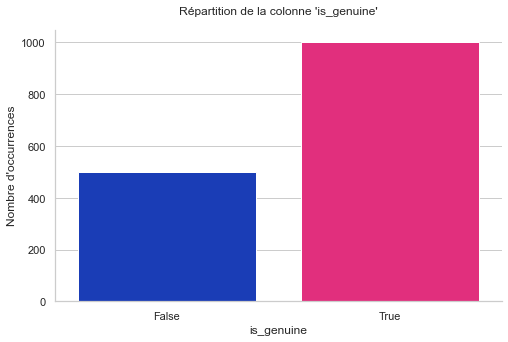

In [25]:
# Afficher le graphique de répartition de la variable is_genuine

# Définir les paramètres personnalisées (palette couleurs + Suppression des axes en haut et à droite)
custom_palette = ["#002fd0", "#ff117a"]
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

# Définir un thème
sns.set_theme(style="whitegrid", rc=custom_params)
value_counts = df_faux_billets["is_genuine"].value_counts()

# Création du barplot
plt.figure(figsize=(8, 5))
sns.barplot(x=value_counts.index, y=value_counts.values, palette=custom_palette)
plt.title("Répartition de la colonne 'is_genuine'", pad=15)
plt.xlabel("is_genuine")
plt.ylabel("Nombre d'occurrences")
plt.show()

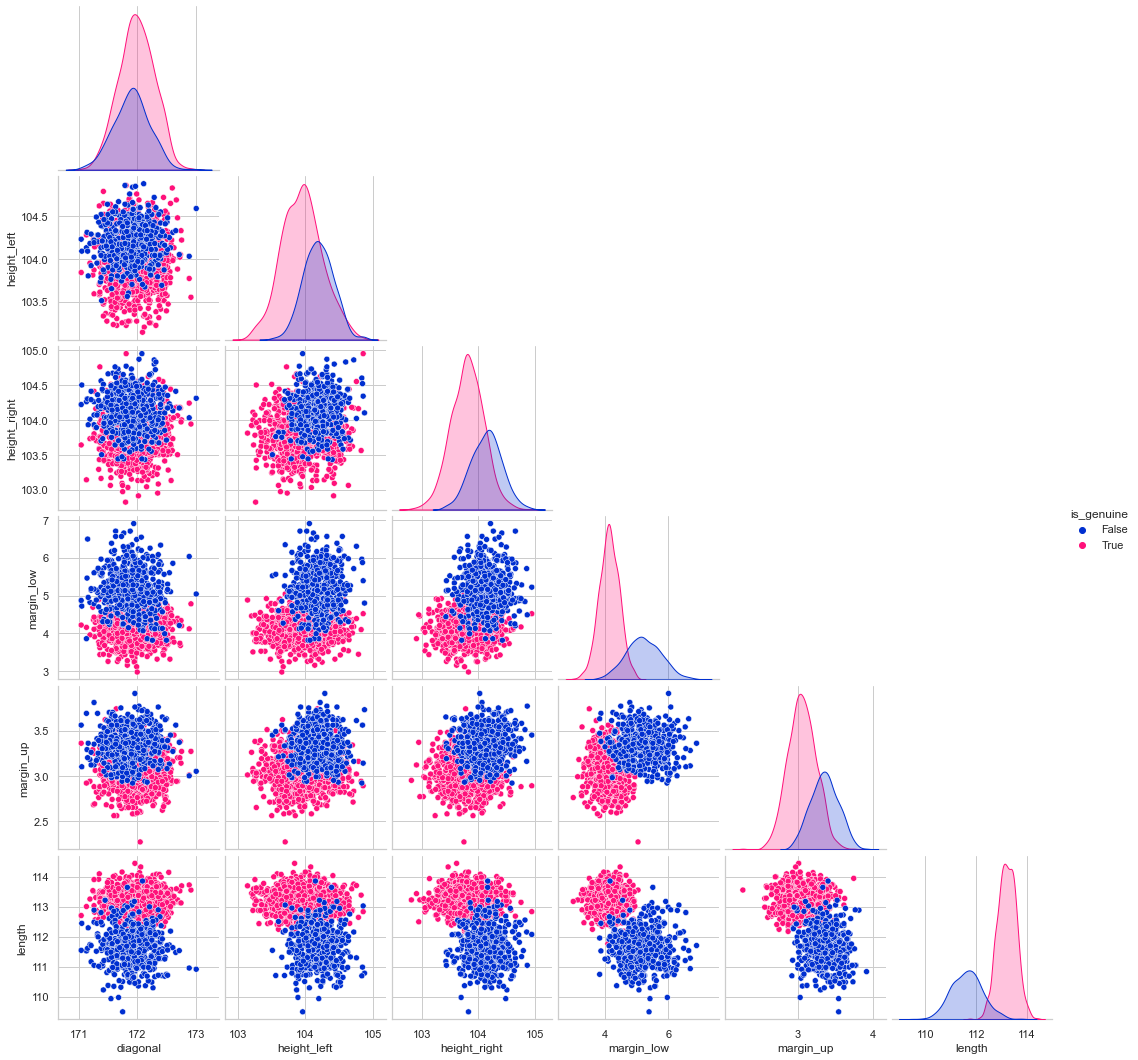

In [26]:
custom_palette = ["#002fd0", "#ff117a"]
sns.pairplot(df_faux_billets, hue="is_genuine", corner=True, palette=custom_palette)
plt.show()

In [27]:
# Créer un dataframe des vrais billets uniquement
df_true = df_faux_billets.loc[df_faux_billets["is_genuine"] == True]
df_true

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
995,True,171.66,103.92,103.47,4.26,2.83,113.20
996,True,172.16,103.72,103.61,4.30,2.72,113.51
997,True,171.78,103.38,104.22,4.23,3.07,113.77
998,True,171.44,103.96,103.92,3.68,2.89,113.21


In [28]:
# Afficher les statistiques descriptives des vrais billets
calculate_descriptive_statistics(df_true)

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
diagonal,1000,147,171.04,172.92,171.987080,171.990,171.790,0.410,172.20,0.300441,0.090265,-0.042787,-0.263071
height_left,1000,148,103.14,104.86,103.949130,103.950,103.740,0.400,104.14,0.300231,0.090138,0.150862,-0.117787
height_right,1000,149,102.82,104.95,103.808650,103.810,103.610,0.390,104.00,0.291570,0.085013,-0.005385,0.280268
margin_low,971,153,2.98,5.04,4.116097,4.110,3.905,0.435,4.34,0.319124,0.101840,-0.100836,0.052632
margin_up,1000,99,2.27,3.74,3.052130,3.050,2.930,0.250,3.18,0.186340,0.034722,0.044081,0.123286
length,1000,168,111.76,114.44,113.202430,113.205,112.950,0.510,113.46,0.359552,0.129278,-0.048781,-0.000823


In [29]:
# Créer un dataframe avec que les faux billets
df_false = df_faux_billets.loc[df_faux_billets["is_genuine"] == False]
df_false

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1000,False,172.28,103.95,103.91,4.78,3.31,111.40
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
1002,False,171.59,104.14,104.38,4.97,3.47,111.22
1003,False,172.02,104.33,104.33,5.19,3.21,111.99
1004,False,172.55,104.25,104.23,5.60,3.13,111.72
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [30]:
# Afficher les statistiques descriptives des faux billets
calculate_descriptive_statistics(df_false)

Statistiques descriptives:


,n,unique,min,max,moy,mediane,q1,iqr,q3,std,var,skew,kurt
diagonal,500,133,171.04,173.01,171.901160,171.91,171.69,0.4025,172.0925,0.306861,0.094164,0.009507,0.158299
height_left,500,103,103.51,104.88,104.190340,104.18,104.04,0.2925,104.3325,0.223758,0.050068,0.060100,0.031825
height_right,500,118,103.43,104.95,104.143620,104.16,103.95,0.3700,104.3200,0.270878,0.073375,-0.014257,-0.096799
margin_low,492,196,3.82,6.90,5.215935,5.19,4.84,0.7525,5.5925,0.553531,0.306397,0.116682,-0.170312
margin_up,500,86,2.92,3.91,3.350160,3.35,3.22,0.2525,3.4725,0.180498,0.032580,0.049122,-0.398423
length,500,209,109.49,113.85,111.630640,111.63,111.20,0.8300,112.0300,0.615543,0.378894,0.113261,0.290306


In [31]:
# Déterminer les variables quantitatives
# Personnalisée une palette de couleurs
quantitative_vars = [
    "diagonal",
    "height_left",
    "height_right",
    "margin_low",
    "margin_up",
    "length",
]

custom_palette = [
    "#002fd0",
    "#c600ab",
    "#ff117a",
    "#ff7452",
    "#ffbb46",
    "#f9f871",
]

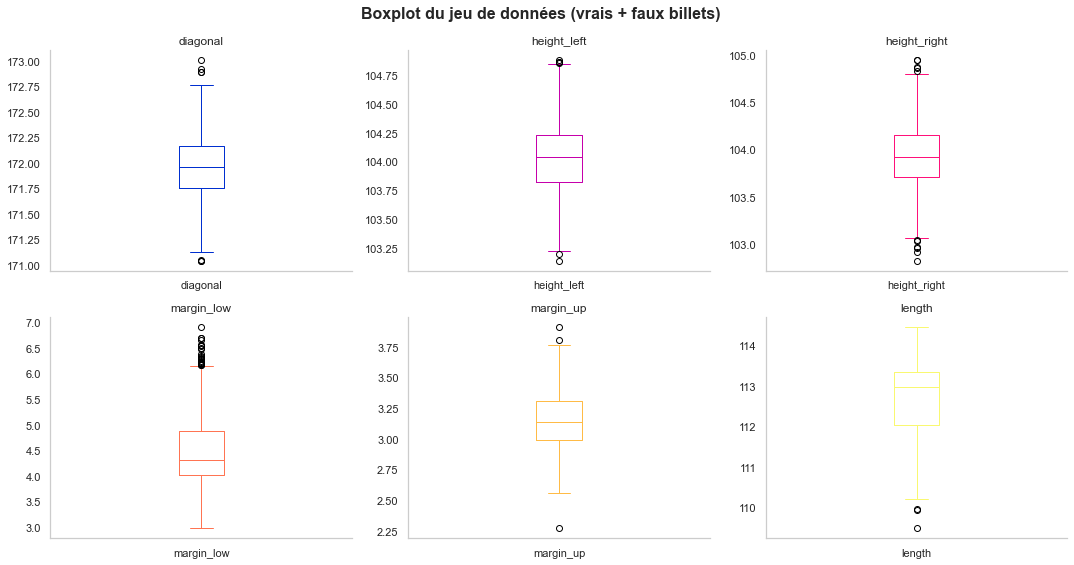

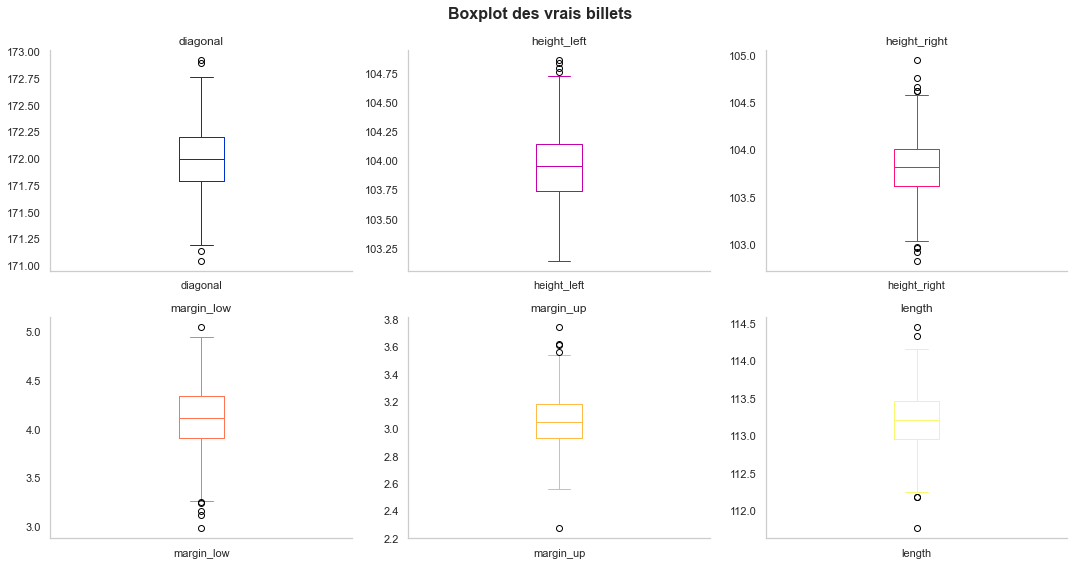

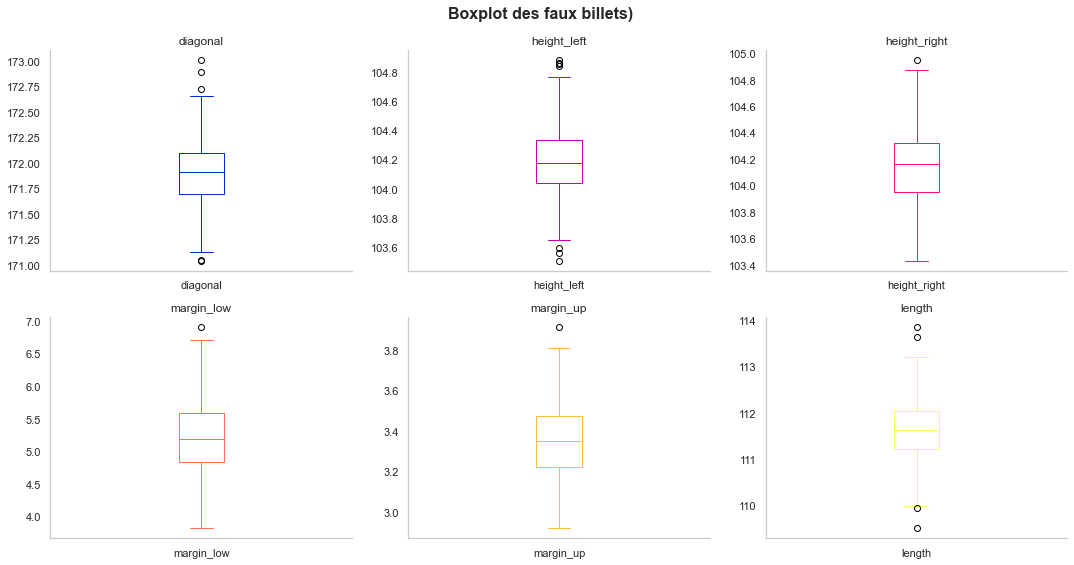

In [32]:
# Afficher les boxplot pour chaque variables
visualize_boxplot(
    df_faux_billets,
    columns=quantitative_vars,
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    palette=custom_palette,
    title="Boxplot du jeu de données (vrais + faux billets)",
)

visualize_boxplot(
    df_true,
    columns=quantitative_vars,
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    palette=custom_palette,
    title="Boxplot des vrais billets",
)


visualize_boxplot(
    df_false,
    columns=quantitative_vars,
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    palette=custom_palette,
    title="Boxplot des faux billets)",
)

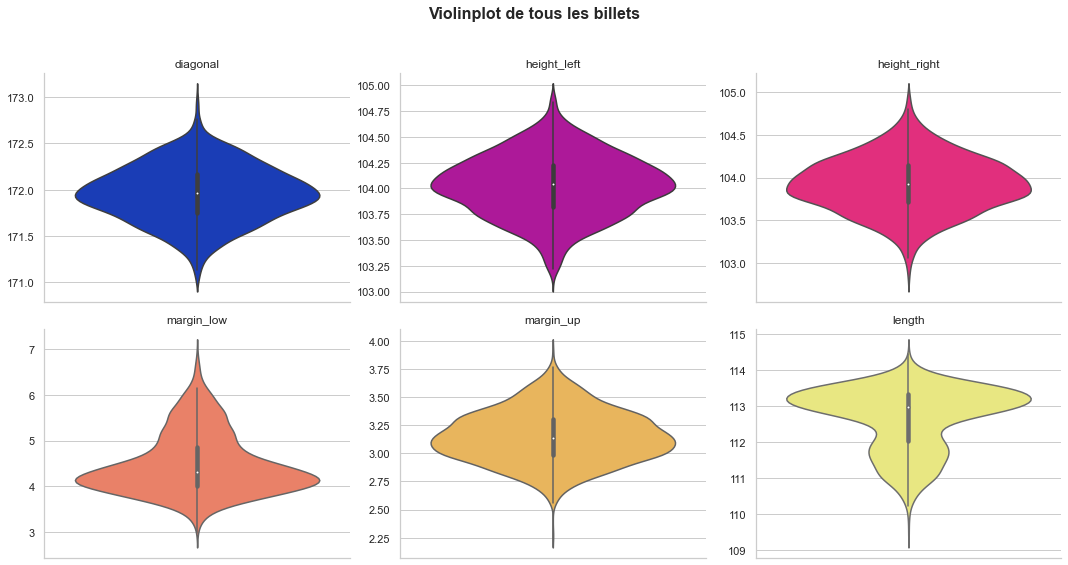

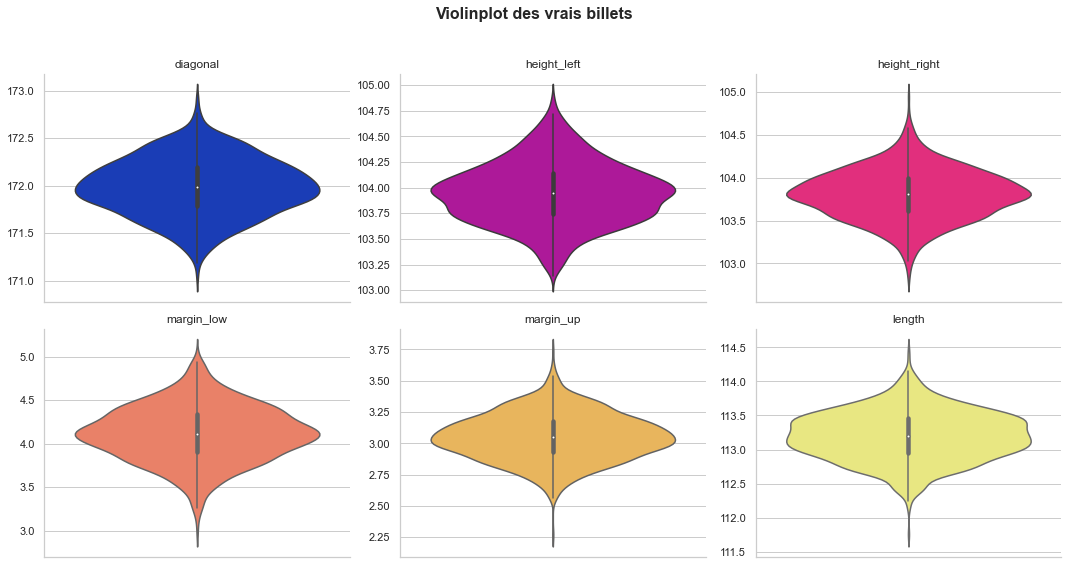

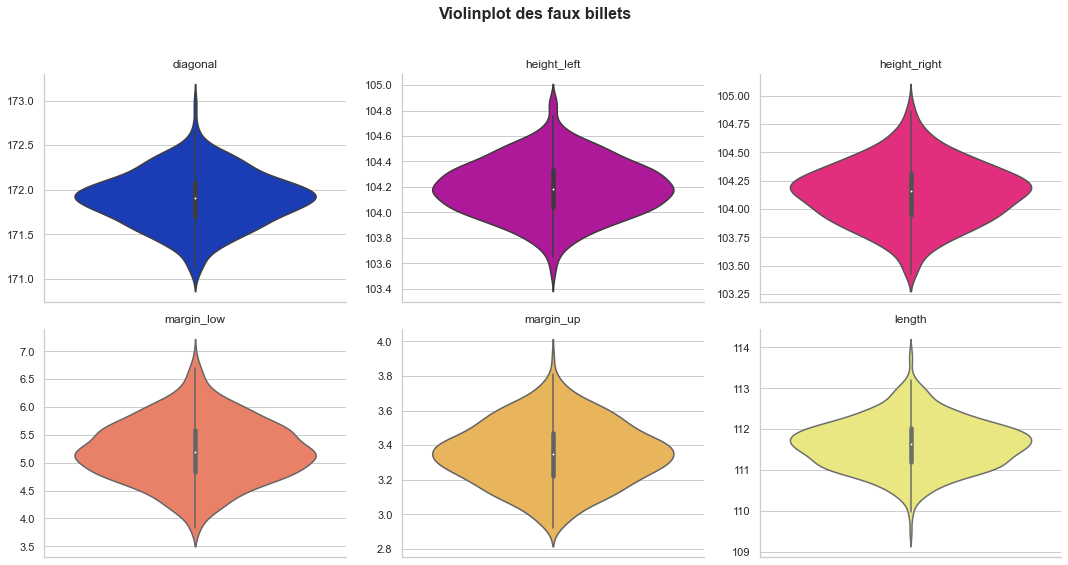

In [33]:
# Afficher les violinplot pour chacunes des variables de chaque dataframe
custom_palette = ["#002fd0", "#c600ab", "#ff117a", "#ff7452", "#ffbb46", "#f9f871"]

visualize_violinplot(
    df_faux_billets,
    quantitative_vars=quantitative_vars,
    color_palette=custom_palette,
    title="Violinplot de tous les billets",
)


visualize_violinplot(
    df_true,
    quantitative_vars,
    color_palette=custom_palette,
    title="Violinplot des vrais billets",
)


visualize_violinplot(
    df_false,
    quantitative_vars,
    color_palette=custom_palette,
    title="Violinplot des faux billets",
)

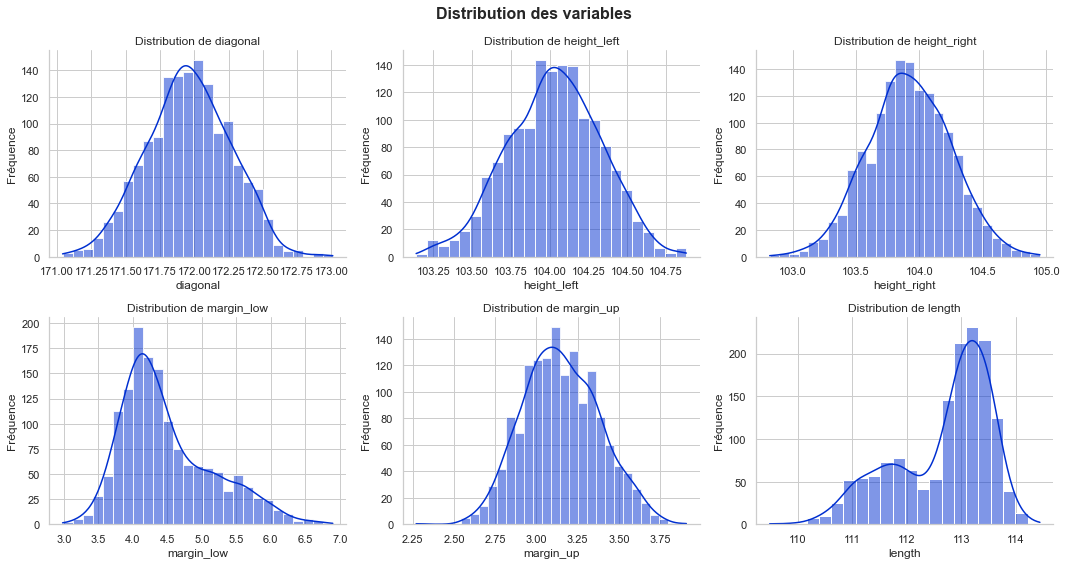

In [34]:
# Afficher les graphiques de la distribution pour chaque variables
visualize_data_distribution(
    df_faux_billets,
    quantitative_vars,
    nrows=2,
    ncols=3,
    figsize=(15, 8),
    title="Distribution des variables",
)

<h3 style="margin: auto; padding: 20px; color: #000000; ">2.2 - Imputation des données manquantes</h3>
</div>

In [35]:
# Vérifier les valeurs manquantes
print(df_faux_billets.isnull().sum())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


In [36]:
# Afficher les données manquantes
missing_data = df_faux_billets.loc[df_faux_billets["margin_low"].isna()]
missing_data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [37]:
# Répartition entre vrai et faux billets (NaN)
missing_data["is_genuine"].value_counts()

True     29
False     8
Name: is_genuine, dtype: int64

On observe 29 vrais et 8 faux billets dans la colonne is_genuine.

In [38]:
# Séparation des données complètes et incomplètes
# Données complètes (train) et incomplètes (test)
complete_data = df_faux_billets[df_faux_billets["margin_low"].notnull()].drop(
    "is_genuine", axis=1
)
incomplete_data = df_faux_billets[df_faux_billets["margin_low"].isnull()].drop(
    "is_genuine", axis=1
)

In [39]:
# Identifier les variables explicatives pertinentes
correlation_matrix = complete_data.corr()
correlation_matrix["margin_low"].head()

diagonal       -0.111534
height_left     0.302643
height_right    0.391085
margin_low      1.000000
margin_up       0.431606
Name: margin_low, dtype: float64

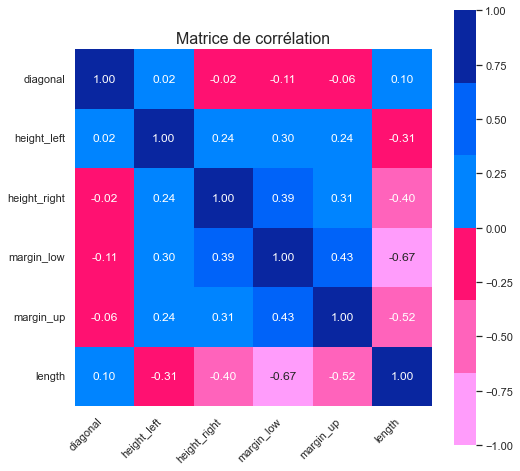

In [40]:
# Définir la palette personnalisée
custom_palette = ["#ff9cfb", "#ff63bb", "#ff1171", "#0084ff", "#0063f9", "#0926A0"]

# Créer la heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Affiche les coefficients de corrélation
    cmap=sns.color_palette(custom_palette),  # Palette de couleurs personnalisée
    fmt=".2f",  # Formate les valeurs avec 2 décimales
    cbar=True,  # Ajoute une barre de couleur
    square=True,  # Forme carrée des cellules
    vmin=-1,
    vmax=1,  # Fixe les limites de la barre de couleurs
)
plt.title("Matrice de corrélation", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [41]:
# Vérifier les valeurs manquantes dans les variables explicatives
print(
    complete_data[["margin_up", "diagonal", "height_left", "height_right", "length"]]
    .isnull()
    .sum()
)

# Pour la cible
print(
    f"margin_low :",
    complete_data["margin_low"].isnull().sum(),
)

margin_up       0
diagonal        0
height_left     0
height_right    0
length          0
dtype: int64
margin_low : 0


<h4 style="margin: auto; padding: 20px; color: #000000; ">2.1.1 - Régression linéaire multiple - sélection backward</h4>
</div>

In [42]:
# Séparation des données complètes et incomplètes
complete_data = df_faux_billets[df_faux_billets["margin_low"].notnull()].drop(
    "is_genuine", axis=1
)
incomplete_data = df_faux_billets[df_faux_billets["margin_low"].isnull()].drop(
    "is_genuine", axis=1
)

# Renommer la variable margin_low du jeu de données complet
target = complete_data["margin_low"]

In [43]:
# Ajuster un modèle de régression linéaire
model_sfs = LinearRegression()

# Utilisation de SequentialFeatureSelector pour la sélection de variables (backward)
sfs = SequentialFeatureSelector(
    model_sfs,
    n_features_to_select="auto",
    direction="backward",
    scoring="neg_mean_squared_error",
    cv=5,
)
sfs = sfs.fit(complete_data.drop("margin_low", axis=1), target)

# Extraction des variables sélectionnées
selected_features = complete_data.drop("margin_low", axis=1).columns[sfs.get_support()]
print("Variables sélectionnées :", selected_features)

# Préparer les données avec les caractéristiques sélectionnées
X_selected = complete_data[selected_features]

# Ajuster le modèle avec les données sélectionnées
model_sfs.fit(X_selected, target)

Variables sélectionnées : Index(['height_right', 'margin_up', 'length'], dtype='object')


LinearRegression()

In [44]:
# Afficher les résultats avec statsmodels
X_selected_with_intercept = sm.add_constant(X_selected)
model_sm = sm.OLS(target, X_selected_with_intercept).fit()

# Afficher les résultats du modèle avec sélection de variables (backward)
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     429.7
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          5.37e-200
Time:                        08:22:12   Log-Likelihood:                -1012.8
No. Observations:                1463   AIC:                             2034.
Df Residuals:                    1459   BIC:                             2055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           23.1826      5.443      4.259   

| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 108.01472176068052                                  |
| P-valeur                   | 0.0                                                 |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |



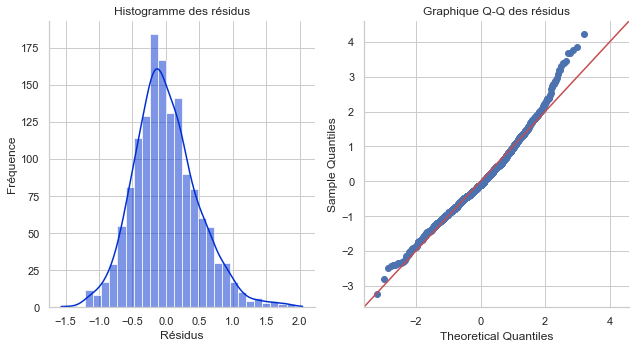

In [45]:
# Récupérer les résidus
residus = model_sm.resid

# Extraire les résidus du modèle
residuals = pd.DataFrame(residus)

# Effectuer un test de normalité jarque bera sur les résidus du modèle
jarque_bera_test(residuals)

In [46]:
# Afficher la moyenne des résidus
moyenne_residus = residuals.mean()
round(moyenne_residus, 4)

0    0.0
dtype: float64

In [47]:
# Afficher l'écart-type des residus
std_residus = residuals.std()
std_residus

0    0.483683
dtype: float64

In [48]:
# Homoscédasticité des résidus (Breusch-Pagan Test)
breusch_pagan_test(residuals, X_selected_with_intercept)

Test de Breusch-Pagan : Statistique=73.9698, p-value=0.0000
Présence d'hétéroscédasticité (variance des résidus non constante).


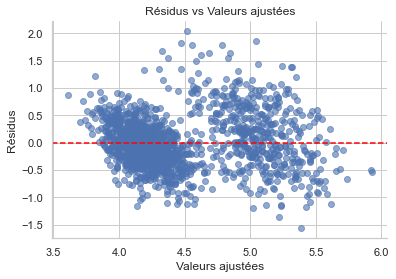

In [49]:
# Afficher le graphique des résidus vs valeurs

plt.scatter(model_sm.fittedvalues, model_sm.resid, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs ajustées")
plt.show()

In [50]:
# Prédire les valeurs manquantes pour 'margin_low'
incomplete_data_selected = incomplete_data[selected_features]
predicted_margin_low = model_sfs.predict(incomplete_data_selected)

In [51]:
# Remplacer les valeurs manquantes dans le DataFrame
df_faux_billets_imputed = df_faux_billets.copy()
df_faux_billets_imputed.loc[df_faux_billets["margin_low"].isnull(), "margin_low"] = (
    predicted_margin_low
)

# Vérification des valeurs manquantes après imputation
print("Valeurs manquantes après imputation :")
print(df_faux_billets_imputed.isnull().sum())

Valeurs manquantes après imputation :
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


In [52]:
# Afficher les performances du modèle
# Prédictions sur les données complètes
y_pred = model_sfs.predict(X_selected)

# Calcul des métriques
r2 = r2_score(target, y_pred)
mae = mean_absolute_error(target, y_pred)
mse = mean_squared_error(target, y_pred)
rmse = np.sqrt(mse)

# Données des résultats (arrondies à 4 chiffres)
data = [
    ["R² ", round(r2, 4)],
    ["MAE", round(mae, 4)],
    ["MSE", round(mse, 4)],
    ["RMSE", round(rmse, 4)],
]

# En-têtes des colonnes
headers = ["Metric", "Score"]

# Génération du tableau avec tabulate
table = tabulate(data, headers=headers, tablefmt="github")

# Afficher les métriques
print(table)

| Metric   |   Score |
|----------|---------|
| R²       |  0.4691 |
| MAE      |  0.3748 |
| MSE      |  0.2338 |
| RMSE     |  0.4835 |


| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 108.01472176068052                                  |
| P-valeur                   | 0.0                                                 |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |



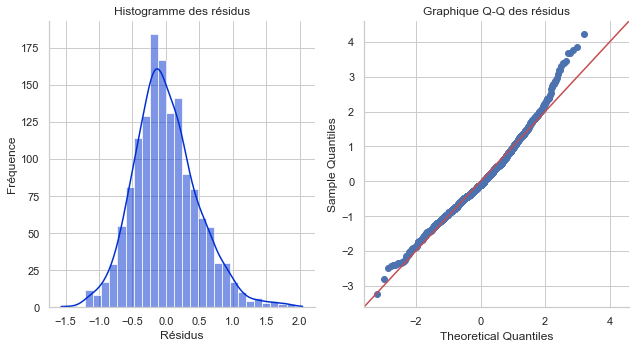

In [53]:
# Récupérer les résidus
residus = model_sm.resid

# Extraire les résidus du modèle
residuals = pd.DataFrame(residus)

# Effectuer un test de normalité jarque bera sur les résidus du modèle
jarque_bera_test(residuals)

In [54]:
# Homoscédasticité des résidus (Breusch-Pagan Test)
breusch_pagan_test(residuals, complete_data)

Test de Breusch-Pagan : Statistique=535.8123, p-value=0.0000
Présence d'hétéroscédasticité (variance des résidus non constante).


In [55]:
# Vérifier la multi
calculate_vif(model_sm)

,Variable,VIF
0,height_right,1.213794
1,margin_up,1.394010
2,length,1.509435


**1<VIF<5** : Niveau modéré de corrélation, acceptable. Il existe une certaine corrélation avec d'autres facteurs prédictifs, mais elle n'est généralement pas très marquée.

In [56]:
# Calculer les mesures d’influence et les valeurs aberrantes.
outliers = model_sm.get_influence()

# Afficher les outliers classés par ordre décroissant de student_resid
outliers = outliers.summary_frame()
outliers.sort_values(by="student_resid", ascending=False, inplace=True)

# Conserver les résidus studentisés et la distance de cook
outliers[["student_resid", "cooks_d"]].head()

,student_resid,cooks_d
1110,4.252190,0.005898
1290,3.858910,0.006575
1473,3.777670,0.004162
1134,3.708181,0.018330
1441,3.687558,0.006955


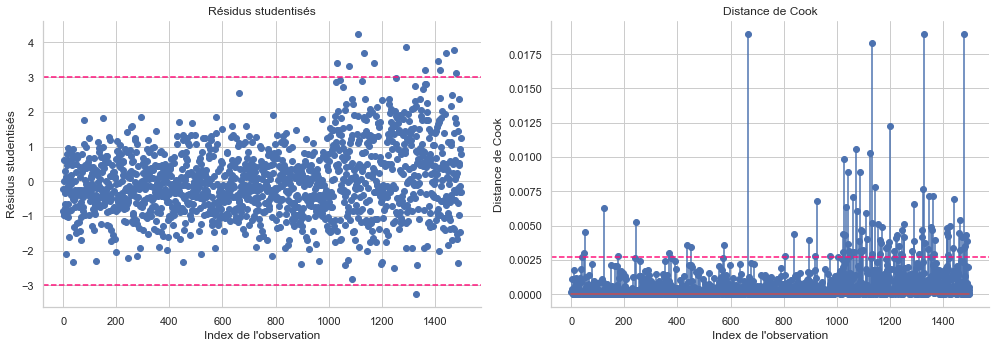

In [57]:
# Créer un  graphique avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique des résidus studentisés
ax1.scatter(outliers.index, outliers["student_resid"])
ax1.axhline(y=3, color="#ff117a", linestyle="--")
ax1.axhline(y=-3, color="#ff117a", linestyle="--")
ax1.set_xlabel("Index de l'observation")
ax1.set_ylabel("Résidus studentisés")
ax1.set_title("Résidus studentisés")

# Graphique de la distance de Cook
ax2.stem(outliers.index, outliers["cooks_d"])
ax2.axhline(y=(4 / complete_data.shape[0]), linestyle="--", color="#ff117a")
ax2.set_xlabel("Index de l'observation")
ax2.set_ylabel("Distance de Cook")
ax2.set_title("Distance de Cook")

plt.tight_layout()
plt.show()

In [58]:
# Afficher les données imputées
missing_data.index
df_faux_billets_imputed.loc[missing_data.index].head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.334553,3.25,112.79
99,True,171.93,104.07,104.18,4.380245,3.14,113.08
151,True,172.07,103.80,104.38,4.465515,3.02,112.93
197,True,171.45,103.66,103.80,4.329474,3.62,113.27
241,True,171.83,104.14,104.06,4.621033,3.02,112.36


In [59]:
# Afficher la description du fichier imputé
summarize_data(df_faux_billets_imputed)

Description donnée(s):
Le jeu de données comporte: 1500 observation(s)
Le jeu de données comporte: 7 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
is_genuine,bool,1500,1500,2,0,0.0
diagonal,float64,1500,1500,159,0,0.0
height_left,float64,1500,1500,155,0,0.0
height_right,float64,1500,1500,170,0,0.0
margin_low,float64,1500,1500,322,0,0.0
margin_up,float64,1500,1500,123,0,0.0
length,float64,1500,1500,336,0,0.0


<h4 style="margin: auto; padding: 20px; color: #000000; ">2.1.2 - Régression LASSO</h4>
</div>

In [60]:
# Séparation des données complètes et incomplètes
complete_data = df_faux_billets[df_faux_billets["margin_low"].notnull()].drop(
    "is_genuine", axis=1
)
incomplete_data = df_faux_billets[df_faux_billets["margin_low"].isnull()].drop(
    "is_genuine", axis=1
)

# Variables explicatives (X) et cible (y)
X = complete_data.drop("margin_low", axis=1)
y = complete_data["margin_low"]

# Définir une grille pour alpha (pénalité L1)
param_grid = {
    "lasso__alpha": [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 10]
}

# Pipeline pour inclure la standardisation et le modèle LASSO
lasso_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardisation
        ("lasso", Lasso(max_iter=10000, random_state=42)),  # Régression LASSO
    ]
)

# Recherche des meilleurs hyperparamètres via GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
)
grid_search.fit(X, y)

# Meilleur modèle
best_pipeline = grid_search.best_estimator_
best_alpha = grid_search.best_params_["lasso__alpha"]

# Variables sélectionnées (coefficients non nuls)
lasso = best_pipeline.named_steps["lasso"]
selected_features = X.columns[lasso.coef_ != 0]

print(f"Meilleur alpha sélectionné : {best_alpha}")
print(f"Variables sélectionnées : {selected_features.tolist()}")

Meilleur alpha sélectionné : 0.001
Variables sélectionnées : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


In [61]:
# Récupérer les coefficients du modèle LASSO
lasso = best_pipeline.named_steps["lasso"]
coefficients = lasso.coef_

# Créer un DataFrame pour afficher les variables et leurs coefficients
features = X.columns
lasso_results = pd.DataFrame({"Feature": features, "Coefficients": coefficients})

# Filtrer pour afficher uniquement les variables sélectionnées (coefficient ≠ 0)
selected_features = lasso_results.loc[lasso_results["Coefficients"] != 0]

# Afficher les résultats
print(f"Meilleur alpha sélectionné : {best_alpha}")
print("Variables sélectionnées et coefs associés:")
print(selected_features)

Meilleur alpha sélectionné : 0.001
Variables sélectionnées et coefs associés:
        Feature  Coefficients
0      diagonal     -0.032960
1   height_left      0.054452
2  height_right      0.082743
3     margin_up      0.058774
4        length     -0.356930


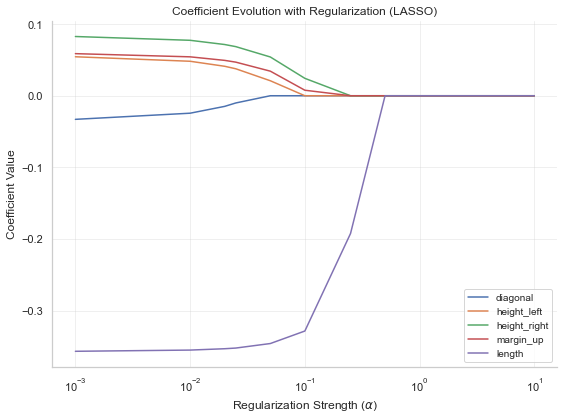

Meilleur alpha sélectionné : 0.001
Variables sélectionnées : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


In [62]:
# Obtenir les coefficients via lasso_path
lasso = best_pipeline.named_steps["lasso"]
scaler = best_pipeline.named_steps["scaler"]

my_alphas = np.array([0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 10])

# Standardiser X avant de passer à lasso_path
X_scaled = scaler.transform(X)

# Utilisation de lasso_path pour obtenir les coefficients
alphas, coefs, _ = lasso_path(X_scaled, y, alphas=my_alphas)

# Tracer l'évolution des coefficients
plt.figure(figsize=(8, 6))
for coef, feature in zip(coefs, X.columns):
    plt.plot(alphas, coef, label=feature)

# Configuration du graphique
plt.xscale("log")  # Échelle logarithmique pour alpha
plt.xlabel(r"Regularization Strength ($\alpha$)")
plt.ylabel("Coefficient Value")
plt.title("Coefficient Evolution with Regularization (LASSO)")
plt.legend(loc="best", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher le meilleur alpha sélectionné et les variables sélectionnées
best_alpha = grid_search.best_params_["lasso__alpha"]
selected_features = X.columns[lasso.coef_ != 0]

print(f"Meilleur alpha sélectionné : {best_alpha}")
print(f"Variables sélectionnées : {selected_features.tolist()}")

Lorsque α est trop élevé, tous les coefficients de la régression sont nuls, nous en avons une illustration ici ; lorsque α est trop faible, proche de 0, nous obtenons les coefficients de la régression linéaire multiple usuelle. Il faut trouver le juste milieu et c’est toute la difficulté de la régression Lasso.

     Alpha  Selected Features
0   10.000                  0
1    1.000                  0
2    0.800                  0
3    0.500                  0
4    0.250                  1
5    0.100                  3
6    0.050                  4
7    0.025                  5
8    0.020                  5
9    0.010                  5
10   0.001                  5


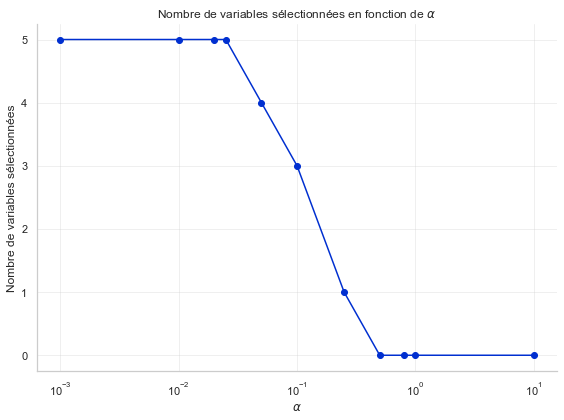

In [63]:
# Standardisation des données (obligatoire avant lasso_path)
scaler = best_pipeline.named_steps["scaler"]
X_scaled = scaler.transform(X)

# Définir une gamme de valeurs pour alpha (échelle logarithmique)
# alphas = np.logspace(-3, 2, 10)
my_alphas = np.array([0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0, 10])

# Obtenir les coefficients pour chaque valeur d'alpha
alphas_path, coefs, _ = lasso_path(X_scaled, y, alphas=my_alphas)

# Calculer le nombre de variables sélectionnées (coefficients non nuls) pour chaque alpha
selected_features_count = (coefs != 0).sum(axis=0)

# Créer un DataFrame pour visualiser les résultats
results = pd.DataFrame(
    {"Alpha": alphas_path, "Selected Features": selected_features_count}
)

# Afficher les mse pour chaque valeur de alpha
print(results.head(15))


# Tracer le nombre de variables sélectionnées en fonction d'alpha
plt.figure(figsize=(8, 6))
plt.plot(results["Alpha"], results["Selected Features"], marker="o", color="#002FD0")
plt.xscale("log")  # Échelle logarithmique pour alpha
plt.title("Nombre de variables sélectionnées en fonction de $\\alpha$")
plt.xlabel("$\\alpha$")
plt.ylabel("Nombre de variables sélectionnées")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

     Alpha       MSE
0    0.001  0.230156
1    0.010  0.230445
2    0.020  0.231322
3    0.025  0.231980
4    0.050  0.236357
5    0.100  0.250380
6    0.250  0.307086
7    0.500  0.440346
8    0.800  0.440346
9    1.000  0.440346
10  10.000  0.440346


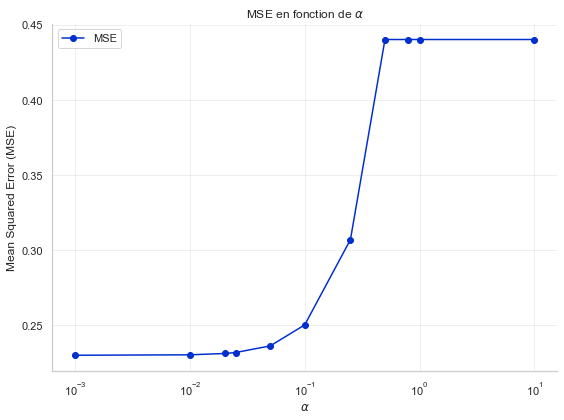

In [64]:
# Définir une gamme de valeurs pour alpha
# alphas = np.logspace(-3, 2, 100)


# Liste pour stocker les MSE
mse_list = []

# Calcul du MSE pour chaque alpha
for alpha in my_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_scaled, y)  # Ajustement du modèle
    y_pred = lasso.predict(X_scaled)  # Prédictions
    mse = mean_squared_error(y, y_pred)  # Calcul du MSE
    mse_list.append(mse)

# Création d'un DataFrame avec les résultats
mse_results = pd.DataFrame({"Alpha": my_alphas, "MSE": mse_list})


# Afficher les mse pour chaque valeur de alpha
print(mse_results.head(15))


# Tracer l'évolution du MSE en fonction d'alpha
plt.figure(figsize=(8, 6))
plt.plot(
    mse_results["Alpha"], mse_results["MSE"], marker="o", color="#002FD0", label="MSE"
)
plt.xscale("log")  # Échelle logarithmique pour alpha
plt.title("MSE en fonction de $\\alpha$")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Normalité des résidus

| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 97.03484100518965                                   |
| P-valeur                   | 0.0                                                 |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |



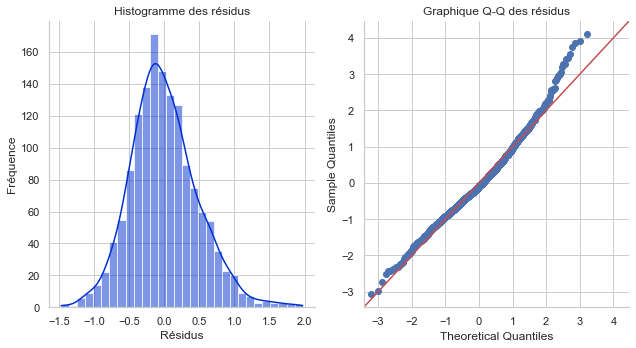

In [65]:
# Calcul des résidus
y_pred = best_pipeline.predict(X)
lasso_residuals = y - y_pred

# Transformer en dataframe
lasso_residuals = pd.DataFrame(lasso_residuals)

# Test de Jarque-Bera
jarque_bera_test(lasso_residuals)

Homoscédasticité

In [66]:
breusch_pagan_test(lasso_residuals, complete_data)

Test de Breusch-Pagan : Statistique=533.5610, p-value=0.0000
Présence d'hétéroscédasticité (variance des résidus non constante).


Multicolinéarité (VIF - Variance Inflation Factor)

In [67]:
# Ajout d'une constante pour le calcul du VIF
X_with_const = sm.add_constant(X[selected_features])

# Calcul du VIF
vif_data = pd.DataFrame(
    {
        "Feature": X_with_const.columns,
        "VIF": [
            variance_inflation_factor(X_with_const.values, i)
            for i in range(X_with_const.shape[1])
        ],
    }
)

# Afficher les résultats du VIF
print("VIF pour les variables sélectionnées :")
print(vif_data)

VIF pour les variables sélectionnées :
        Feature            VIF
0         const  590198.238883
1      diagonal       1.013613
2   height_left       1.138261
3  height_right       1.230115
4     margin_up       1.404404
5        length       1.576950


**1<VIF<5** : Niveau modéré de corrélation, acceptable. Il existe une certaine corrélation avec d'autres facteurs prédictifs, mais elle n'est généralement pas très marquée.

In [68]:
# Prédire les valeurs manquantes pour margin_low
incomplete_data_lasso = incomplete_data[selected_features]

# Appliquer la même transformation (standardisation) que pour les données complètes
incomplete_data_lasso_scaled = best_pipeline.named_steps["scaler"].transform(
    incomplete_data[selected_features]
)
predicted_margin_low = best_pipeline.predict(incomplete_data_lasso_scaled)

# Remplacer les valeurs manquantes dans le DataFrame original
df_faux_billets_imputed = df_faux_billets.copy()
df_faux_billets_imputed.loc[df_faux_billets["margin_low"].isnull(), "margin_low"] = (
    predicted_margin_low
)

# afficher les premières lignes du DataFrame imputé
df_faux_billets_imputed.head()

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [69]:
# Evaluer les performances du modèle
# Prédire les valeurs sur les données complètes
y_pred = best_pipeline.predict(X)

# Calcul des métriques
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

# Données des résultats (arrondies à 4 chiffres)
data = [
    ["R²", round(r2, 4)],
    ["MAE", round(mae, 4)],
    ["MSE", round(mse, 4)],
    ["RMSE", round(rmse, 4)],
]

# En-têtes des colonnes
headers = ["Metric", "Score"]

# Génération du tableau avec tabulate
table = tabulate(data, headers=headers, tablefmt="github")

# Afficher les résultats
print(table)

| Metric   |   Score |
|----------|---------|
| R²       |  0.4773 |
| MAE      |  0.3722 |
| MSE      |  0.2302 |
| RMSE     |  0.4797 |


Le modèle LASSO est plus performant que la sélection backward. Ainsi, se sont les variables retenues par ce modèle qui seront utilisées pour l'étape d'imputation des données manquantes. Cependant les conditions de validité ne sont pas toutes respectées, un ajustement du modèle doit être effectué.

<h4 style="margin: auto; padding: 20px; color: #000000; ">2.1.3 - Ajuster le modèle</h4>
</div>

Je conserve les résultats de la modélisation LASSO à savoir les variables sélectionnées puis ajuste un nouveau modèle de régression linéaire multiple.

J'applique une transformation de type inverse, méthode couramment utilisée pour stabiliser la variance dans le contexte d'une régression lorsque l'hétéroscédasticité est détectée.

Ainsi, celle-ci est appliquée à la variable cible : target_transformed = 1/target

In [70]:
complete_data["margin_low_inverse"] = 1 / complete_data["margin_low"]

# Variables explicatives et cible transformée
X = complete_data.drop(["margin_low", "margin_low_inverse"], axis=1)
y_transformed = complete_data["margin_low_inverse"]

In [71]:
X_with_const = sm.add_constant(X)  # Ajout de l'intercept

# Ajustement du modèle OLS
ols_model = sm.OLS(y_transformed, X_with_const).fit()

# Résumé du modèle
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:     margin_low_inverse   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     245.9
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.25e-190
Time:                        08:22:21   Log-Likelihood:                 3447.7
No. Observations:                1463   AIC:                            -6883.
Df Residuals:                    1457   BIC:                            -6852.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4655      0.461     -1.009   

| Métrique                   | Valeur                                              |
|----------------------------|-----------------------------------------------------|
| Statistique de Jarque-Bera | 17.316783293940347                                  |
| P-valeur                   | 0.00017366339445434864                              |
| Conclusion                 | Les résidus ne suivent pas une distribution normale |



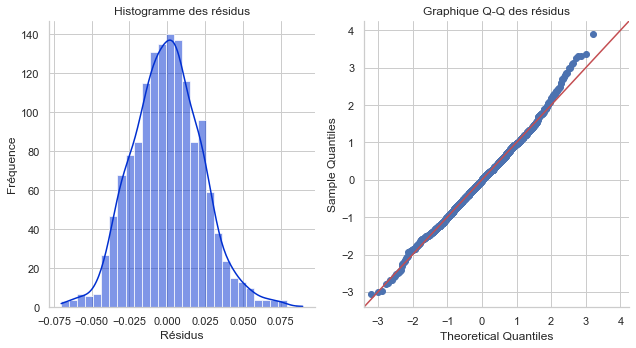

In [72]:
# Effectuer un test de normalité
residuals_3 = pd.DataFrame(ols_model.resid)
jarque_bera_test(residuals_3)

In [73]:
round(residuals_3.mean(), 4)

0    0.0
dtype: float64

In [74]:
residuals_3.std()

0    0.022932
dtype: float64

Test de Breusch-Pagan : Statistique=4.5190, p-value=0.4773
Homoscédasticité confirmée.


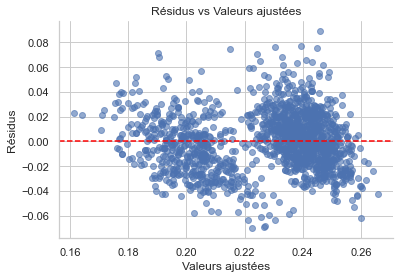

In [75]:
# Vérifier la présence d'hétéroscédasticité
variables = pd.DataFrame(ols_model.model.exog)
breusch_pagan_test(residuals_3, variables)

plt.scatter(ols_model.fittedvalues, ols_model.resid, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valeurs ajustées")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs ajustées")
plt.show()

Le problème d'hétéroscédasticité à été résolus

In [76]:
# Calculer les VIF sur chaque variables
calculate_vif(ols_model)

,Variable,VIF
0,diagonal,1.013613
1,height_left,1.138261
2,height_right,1.230115
3,margin_up,1.404404
4,length,1.576950


**1<VIF<5** : Niveau modéré de corrélation, acceptable. Il existe une certaine corrélation avec d'autres facteurs prédictifs, mais elle n'est généralement pas très marquée.

In [77]:
# Extraire les variables explicatives de incomplete_data (en excluant margin_low et is_genuine)
X_incomplete = incomplete_data.drop(["margin_low"], axis=1)

# Ajouter une constante aux variables explicatives de incomplete_data
X_incomplete_with_const = sm.add_constant(X_incomplete)

# Vérifier que les colonnes de incomplete_data correspondent aux colonnes utilisées pour entraîner ols_model
missing_cols = set(X_with_const.columns) - set(X_incomplete_with_const.columns)
if missing_cols:
    raise ValueError(
        f"Les colonnes suivantes sont manquantes dans incomplete_data : {missing_cols}"
    )

# Effectuer les prédictions pour margin_low_inverse
predicted_margin_low_inverse = ols_model.predict(X_incomplete_with_const)

# Retourner les valeurs originales de margin_low en prenant l'inverse
predicted_margin_low = 1 / predicted_margin_low_inverse

# Remplacer les valeurs manquantes dans df_faux_billets
df_faux_billets_imputed = df_faux_billets.copy()
df_faux_billets_imputed.loc[df_faux_billets["margin_low"].isnull(), "margin_low"] = (
    predicted_margin_low
)

In [78]:
# Générer les prédictions sur les données d'entraînement
y_pred = ols_model.predict(X_with_const)

# Calcul des métriques
r2 = r2_score(y_transformed, y_pred)
mae = mean_absolute_error(y_transformed, y_pred)
mse = mean_squared_error(y_transformed, y_pred)
rmse = np.sqrt(mse)

# Affichage des résultats
metrics = [
    ["R² ", round(r2, 4)],
    ["MAE", round(mae, 4)],
    ["MSE", round(mse, 4)],
    ["RMSE", round(rmse, 4)],
]

# En-têtes des colonnes
headers = ["Metric", "Score"]

# Génération du tableau avec tabulate
table = tabulate(metrics, headers=headers, tablefmt="github")

# Afficher les résultats
print(table)

| Metric   |   Score |
|----------|---------|
| R²       |  0.4576 |
| MAE      |  0.0181 |
| MSE      |  0.0005 |
| RMSE     |  0.0229 |


In [79]:
# Afficher les premières lignes du DataFrame imputé
df_faux_billets_imputed.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [80]:
# Afficher une description des données - vérifier qu'il n'y a plus de NaN
summarize_data(df_faux_billets_imputed)

Description donnée(s):
Le jeu de données comporte: 1500 observation(s)
Le jeu de données comporte: 7 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
is_genuine,bool,1500,1500,2,0,0.0
diagonal,float64,1500,1500,159,0,0.0
height_left,float64,1500,1500,155,0,0.0
height_right,float64,1500,1500,170,0,0.0
margin_low,float64,1500,1500,322,0,0.0
margin_up,float64,1500,1500,123,0,0.0
length,float64,1500,1500,336,0,0.0


In [81]:
# Exporter le fichier imputé au format csv
df_faux_billets_imputed.to_csv("df_faux_billets_imputed.csv", index=False)

<h3 style="margin: auto; padding: 20px; color: #000000; ">2.3 - Séparer le jeu de données en train et test</h3>
</div>

In [82]:
# Convertir en valeurs numériques si nécessaire
X = df_faux_billets.drop(columns=["is_genuine"])
y = df_faux_billets["is_genuine"].astype(
    int
)  # Convertir en valeurs numériques si nécessaire

In [83]:
# Spliter les données (avec répartition équilibrée des classes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [84]:
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [85]:
# Afficher les dimensions dans chacun des jeu de données
print(f"Dimensions de X_train :", X_train.shape)
print(f"Dimensions de X_test :", X_test.shape)
print(f"Dimensions de y_train :", y_train.shape)
print(f"Dimensions de y_test :", y_test.shape)

Dimensions de X_train : (1050, 6)
Dimensions de X_test : (450, 6)
Dimensions de y_train : (1050,)
Dimensions de y_test : (450,)


In [86]:
# Afficher la description des données d'entrainement
summarize_data(X_train)

Description donnée(s):
Le jeu de données comporte: 1050 observation(s)
Le jeu de données comporte: 6 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
margin_low,float64,1050,1026,265,24,2.29
diagonal,float64,1050,1050,148,0,0.00
height_left,float64,1050,1050,149,0,0.00
height_right,float64,1050,1050,162,0,0.00
margin_up,float64,1050,1050,118,0,0.00
length,float64,1050,1050,310,0,0.00


In [87]:
# Afficher la description des données test
summarize_data(X_test)

Description donnée(s):
Le jeu de données comporte: 450 observation(s)
Le jeu de données comporte: 6 colonne(s)


,type,total,n,unique,NaN,pourcentage_(NaN)
margin_low,float64,450,437,205,13,2.89
diagonal,float64,450,450,127,0,0.00
height_left,float64,450,450,124,0,0.00
height_right,float64,450,450,132,0,0.00
margin_up,float64,450,450,103,0,0.00
length,float64,450,450,223,0,0.00


<h2 style="margin: auto; padding: 20px; color:#000000; ">Etape 3 - Développer et tester les différents algorithmes</h2>
</div>

**Processus :**

Diviser les données en deux ensembles, le premier en données d'entrainement (70%), le second en données test (30%) avec répartition équilibrée des classes. (ci-dessus)

Construction de Pipeline Scikit-Learn pour chacun des algorithmes. Ceux-ci vont permettrent de rationnaliser les flux de travail d'apprentissage automatique en combinant le prétraitement des données et la formation des modèles dans un processus unique, cohérent et reproductible.

Ces pipelines automatisent un séquencement d'étapes de transformations de données et de formation de modèles.

3 opérations vont être définies dans chacun d'eux :
1. L'imputation des données manquantes à l'aide d'une class personnalisée; (Imputer)
2. La standardisation des données; (StandardScaler)
3. L'éxécution du classifier (Algorithme)

L'imputation des données manquantes s'effectue à l'aide des résultats de la régression LASSO et d'un ajustement du modèle de régression linéaire, réalisé précèdemment.
Les variables sont nommées explicitement. ('diagonal', 'height_left', 'height_right', 'margin_up', 'length')

A postériori, une analyse en composante principale est utilisée à des fins de visualisation des résultats sur un plan factoriel. (2 premières dimensions).

Enfin, les performances des modèles sont évalués à l'aide des metrics suivantes : 
- **Accuracy :** mesure la proportion de prédictions correctes par rapport au total des échantillons.
- **F1-score :** est la moyenne harmonique entre la précision et le rappel. Combine les deux métriques pour trouver un équilibre.
- **Precision :** mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives.
- **Recall :** mesure la proportion des cas positifs correctement détectés parmi tous les cas positifs réels.
- **AUC :** prend en compte tous les seuils de classement entre 0 et 1.

Les pipelines et modèles optimisés sont sauvegardés à l'aide de joblib au format .pkl

En conclusion, une synthèse des résultats compare les différents algorithmes.


<h3 style="margin: auto; padding: 20px; color: #000000; ">3.1 - Kmeans</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.1.1 - Description des données</h4>
</div>

In [88]:
# Afficher les dimensions dans chacun des jeux de données
print(f"Dimensions de X_train :", X_train.shape)
print(f"Dimensions de X_test :", X_test.shape)
print(f"Dimensions de y_train :", y_train.shape)
print(f"Dimensions de y_test :", y_test.shape)

Dimensions de X_train : (1050, 6)
Dimensions de X_test : (450, 6)
Dimensions de y_train : (1050,)
Dimensions de y_test : (450,)


In [89]:
# Afficher le nombre de données manquantes dans chacun des datasets
train_missing_before = X_train["margin_low"].isna().sum()
test_missing_before = X_test["margin_low"].isna().sum()

print(f"Nombre de données manquantes dans X_train :", train_missing_before)
print(f"Nombre de données manquantes dans X_test :", test_missing_before)

Nombre de données manquantes dans X_train : 24
Nombre de données manquantes dans X_test : 13


<h4 style="margin: auto; padding: 20px; color: #000000; ">3.1.2 - Construire le pipeline</h4>
</div>

In [90]:
# Liste des colonnes prédictrices
predictor_columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

# Créer le pipeline
clf_kmeans = Pipeline(
    [
        (
            "imputer",
            StaticLinearRegressionImputer(
                target_column="margin_low", predictor_columns=predictor_columns
            ),
        ),
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=2, random_state=42)),
    ]
)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.1.3 - Entrainer le modèle sur les données d'entrainement</h4>
</div>

In [91]:
# Entraîner le pipeline sur les données d'entraînement
clf_kmeans.fit(X_train)

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=2, random_state=42))])

In [92]:
# Accéder à l'étape 'imputer' du pipeline
imputer_step = clf_kmeans.named_steps["imputer"]

# Extraire les informations pour le tableau
features = imputer_step.selected_features
coefficients = imputer_step.model.coef_
intercept = imputer_step.model.intercept_
r2_score_imputer = imputer_step.r2_score_
mae_score_imputer = imputer_step.mae_
mse_score_imputer = imputer_step.mse_
rmse_score_imputer = imputer_step.rmse_

# Créer un tableau pour les coefficients et les features
data = []
for feature, coef in zip(features, coefficients):
    data.append([feature, coef])


# Générer le tableau avec tabulate
table = tabulate(
    data,
    headers=["Variables", "Coef"],
    tablefmt="github",
    floatfmt=".4f",
)

# Données des résultats
imputer_metrics = [
    ["R²", round(r2_score_imputer, 4)],
    ["Intercept", round(imputer_step.model.intercept_, 4)],
    ["MAE", round(imputer_step.mae_, 4)],
    ["MSE", round(imputer_step.mse_, 4)],
    ["RMSE", round(imputer_step.rmse_, 4)],
]

# En-têtes des colonnes
headers = ["Metrics", "Score"]

# Affichage avec tabulate
table_2 = tabulate(imputer_metrics, headers=headers, tablefmt="github")

# Afficher le tableau
# Afficher les caractéristiques utilisées pour l'imputation
print("Variables utilisées pour l'imputation :", imputer_step.selected_features)
print("\n" * 1)
print("Résultats de la régression :\n")
print(table)
print("\n" * 1)
print("Performances du modèle :\n")
print(table_2)

Variables utilisées pour l'imputation : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


Résultats de la régression :

| Variables    |    Coef |
|--------------|---------|
| diagonal     |  0.0027 |
| height_left  | -0.0089 |
| height_right | -0.0118 |
| margin_up    | -0.0144 |
| length       |  0.0179 |


Performances du modèle :

| Metrics   |   Score |
|-----------|---------|
| R²        |  0.4573 |
| Intercept | -0.0511 |
| MAE       |  0.0175 |
| MSE       |  0.0005 |
| RMSE      |  0.0225 |


In [93]:
# Accéder à l'étape 'imputer'
imputer_step = clf_kmeans.named_steps["imputer"]

# Extraire les informations sur les valeurs manquantes
missing_before = imputer_step.missing_before_
missing_after = imputer_step.missing_after_

# Afficher les résultats
print(f"Valeurs manquantes avant transformation : {missing_before}")
print(f"Valeurs manquantes après transformation : {missing_after}")

Valeurs manquantes avant transformation : 24
Valeurs manquantes après transformation : 0


In [94]:
# Afficher les paramètres mis à jour du pipeline
clf_kmeans.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('kmeans', KMeans(n_clusters=2, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'kmeans': KMeans(n_clusters=2, random_state=42),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'scaler__copy': True,
 'sca

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.1.4 - Réaliser les prédictions sur les données test</h4>
</div>

In [95]:
# Faire des prédictions sur le jeu de test
y_pred_kmeans = clf_kmeans.predict(X_test)

In [96]:
# Extraire les clusters
cluster_labels = clf_kmeans.named_steps["kmeans"].labels_

# Créer un mapping des clusters -> étiquettes en utilisant y_train
cluster_mapping = {}
for cluster in np.unique(cluster_labels):
    mask = cluster_labels == cluster
    majority_class = y_train[mask].mode()[0]  # Classe majoritaire dans ce cluster
    cluster_mapping[cluster] = majority_class


# Extraire les barycentres
centroids = clf_kmeans.named_steps["kmeans"].cluster_centers_
centroids

array([[-0.20153597,  0.54281426,  0.71602514,  1.12550411,  0.87231997,
        -1.21123482],
       [ 0.09862399, -0.26563251, -0.35039528, -0.55077861, -0.42687998,
         0.59273193]])

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.1.5 - Evaluer les performances</h4>
</div>

In [97]:
# Évaluer les performances
print(classification_report(y_test, y_pred_kmeans))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       150
           1       0.99      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



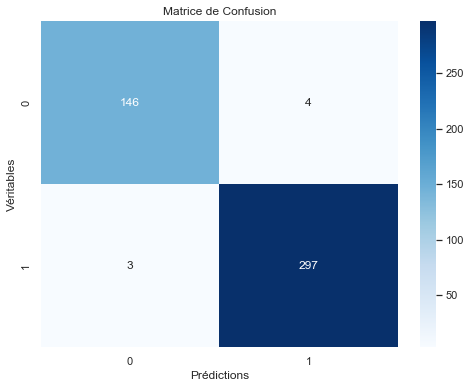

array([[146,   4],
       [  3, 297]], dtype=int64)

In [98]:
# Afficher la matrice de confusion
visualize_confusion_matrix(y_test, y_pred_kmeans, labels=[0, 1])

- TP : true positive, vrai positif : billets positifs prédits comme positifs. (quadrant inférieur droit) soit **297**

- FP : false positive, faux positif : billets négatifs prédits comme positifs de façon erronée. (quadrant supérieur droit) soit **4**

- TN : true negative, vrai négatif : billets négatifs prédits comme négatifs. (quadrant supérieur gauche) soit **146**

- FN : false negative, faux négatif : billets positifs prédits comme négatifs de façon erronée. (quadrant inférieur gauche) soit **3**

In [99]:
# Synthèse des performances du modèle
calculate_model_metrics(y_test, y_pred_kmeans)

| Metric    |    Value |
|-----------|----------|
| Accuracy  | 0.984444 |
| F1-score  | 0.988353 |
| Precision | 0.986711 |
| Recall    | 0.99     |
| Auc       | 0.981667 |


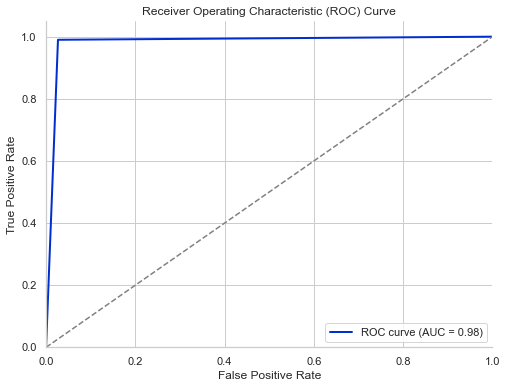

In [100]:
# Afficher la courbe de ROC et l'AUC
visualize_roc_curve(y_test, y_pred_kmeans)

L'AUC mesurée à 0,981 confirme la performance du modèle de classification. 

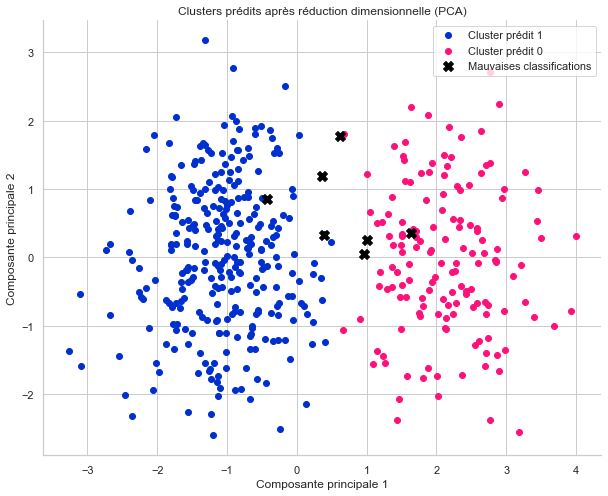

In [101]:
# Afficher les prédictions à l'aide d'une acp sur les 2 premières dimensions
# Transformation des données de test
X_test_transformed = clf_kmeans[:-1].transform(X_test)
y_test_kmeans_pred = clf_kmeans.named_steps["kmeans"].predict(
    X_test_transformed
)  # Clustering

pca = PCA(n_components=2)
X_test_kmeans_2d = pca.fit_transform(X_test_transformed)

# Créer un DataFrame pour faciliter la visualisation
df_viz = pd.DataFrame(
    {
        "x": X_test_kmeans_2d[:, 0],
        "y": X_test_kmeans_2d[:, 1],
        "true_class": y_test,
        "predicted_class": y_test_kmeans_pred,
    }
)

# Appeler la fonction de visualisation
colors = ["#002FD0", "#FF117A"]  # Ajouter autant de couleurs que de clusters
visualize_classification_results(df_viz, colors)

<h3 style="margin: auto; padding: 20px; color: #000000; ">3.2 - KNN</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.2.1 - Description des données</h4>
</div>

In [102]:
# Afficher les dimensions dans chacun des jeux de données
print(f"Dimensions de X_train :", X_train.shape)
print(f"Dimensions de X_test :", X_test.shape)
print(f"Dimensions de y_train :", y_train.shape)
print(f"Dimensions de y_test :", y_test.shape)

Dimensions de X_train : (1050, 6)
Dimensions de X_test : (450, 6)
Dimensions de y_train : (1050,)
Dimensions de y_test : (450,)


In [103]:
# Afficher le nombre de données manquantes dans chacun des datasets
train_missing_before = X_train["margin_low"].isna().sum()
test_missing_before = X_test["margin_low"].isna().sum()

print(f"Nombre de données manquantes dans X_train :", train_missing_before)
print(f"Nombre de données manquantes dans X_test :", test_missing_before)

Nombre de données manquantes dans X_train : 24
Nombre de données manquantes dans X_test : 13


<h4 style="margin: auto; padding: 20px; color: #000000; ">3.2.2 - Construire le pipeline</h4>
</div>

In [104]:
# Liste des colonnes prédictrices
predictor_columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

# Créer le pipeline avec un modèle KNN (sans hyperparamètres fixes pour le moment)
clf_knn = Pipeline(
    [
        (
            "imputer",
            StaticLinearRegressionImputer(
                target_column="margin_low", predictor_columns=predictor_columns
            ),
        ),  # Remplacez "target_column_name" par la colonne cible
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(p=2)),
    ]
)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.2.3 - Entrainer le modèle sur les données d'entrainement</h4>
</div>

In [105]:
# Modéliser un premier modèle
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [106]:
# Accéder à l'étape 'imputer' du pipeline
imputer_step = clf_knn.named_steps["imputer"]

# Extraire les informations pour le tableau
features = imputer_step.selected_features
coefficients = imputer_step.model.coef_
intercept = imputer_step.model.intercept_
r2_score_imputer = imputer_step.r2_score_
mae_score_imputer = imputer_step.mae_
mse_score_imputer = imputer_step.mse_
rmse_score_imputer = imputer_step.rmse_

# Créer un tableau pour les coefficients et les features
data = []
for feature, coef in zip(features, coefficients):
    data.append([feature, coef])


# Générer le tableau avec tabulate
table = tabulate(
    data,
    headers=["Variables", "Coef"],
    tablefmt="github",
    floatfmt=".4f",
)

# Données des résultats
imputer_metrics = [
    ["R²", round(r2_score_imputer, 4)],
    ["Intercept", round(imputer_step.model.intercept_, 4)],
    ["MAE", round(imputer_step.mae_, 4)],
    ["MSE", round(imputer_step.mse_, 4)],
    ["RMSE", round(imputer_step.rmse_, 4)],
]

# En-têtes des colonnes
headers = ["Metrics", "Score"]

# Affichage avec tabulate
table_2 = tabulate(imputer_metrics, headers=headers, tablefmt="github")

# Afficher le tableau
# Afficher les caractéristiques utilisées pour l'imputation
print("Variables utilisées pour l'imputation :", imputer_step.selected_features)
print("\n" * 1)
print("Résultats de la régression :\n")
print(table)
print("\n" * 1)
print("Performances du modèle :\n")
print(table_2)

Variables utilisées pour l'imputation : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


Résultats de la régression :

| Variables    |    Coef |
|--------------|---------|
| diagonal     |  0.0027 |
| height_left  | -0.0089 |
| height_right | -0.0118 |
| margin_up    | -0.0144 |
| length       |  0.0179 |


Performances du modèle :

| Metrics   |   Score |
|-----------|---------|
| R²        |  0.4573 |
| Intercept | -0.0511 |
| MAE       |  0.0175 |
| MSE       |  0.0005 |
| RMSE      |  0.0225 |


In [107]:
# Accéder à l'étape 'imputer'
imputer_step = clf_knn.named_steps["imputer"]

# Extraire les informations sur les valeurs manquantes
missing_before = imputer_step.missing_before_
missing_after = imputer_step.missing_after_

# Afficher les résultats
print(f"Valeurs manquantes avant transformation : {missing_before}")
print(f"Valeurs manquantes après transformation : {missing_after}")

Valeurs manquantes avant transformation : 24
Valeurs manquantes après transformation : 0


In [108]:
# Afficher les paramètres du pipeline
clf_knn.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__wit

In [109]:
# Définition de la grille d'hyperparamètres pour GridSearchCV
param_grid = {
    "knn__n_neighbors": range(1, 21),  # Explore les valeurs de k
    "knn__weights": ["uniform", "distance"],  # Explore les deux types de poids
}

# Initialisation de la recherche avec validation croisée
grid_search = GridSearchCV(
    clf_knn,
    param_grid,
    cv=5,  # Nombre de plis de validation croisée
    scoring="accuracy",  # Critère d'évaluation
    n_jobs=-1,  # Utilise tous les cœurs disponibles pour accélérer
    verbose=2,  # Affiche les détails de la progression
)

In [110]:
# Ajuster GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Meilleurs paramètres trouvés : {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


In [111]:
# Récupérer les meilleurs paramètres trouvés par GridSearchCV
best_params = grid_search.best_params_

# Mettre à jour le pipeline avec les meilleurs paramètres
clf_knn.set_params(**best_params)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [112]:
# Réentraîner le pipeline mis à jour sur le jeu de données d'entraînement complet
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

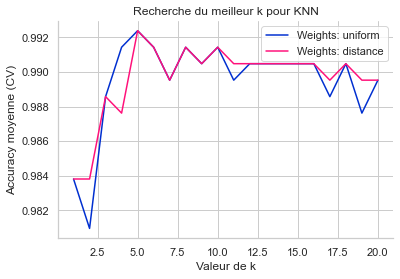

In [113]:
# Tracé des courbes de validation croisée (facultatif, basé sur vos résultats précédents)
results = grid_search.cv_results_
k_values = range(1, 21)

# Palette de couleurs personnalisée
colors = {"uniform": "#002FD0", "distance": "#ff117a"}

# Extraction des scores pour chaque méthode de poids
for weights in ["uniform", "distance"]:
    mean_scores = [
        results["mean_test_score"][i]
        for i, param in enumerate(results["params"])
        if param["knn__weights"] == weights
    ]
    plt.plot(k_values, mean_scores, label=f"Weights: {weights}", color=colors[weights])

# Affichage des courbes
plt.xlabel("Valeur de k")
plt.ylabel("Accuracy moyenne (CV)")
plt.title("Recherche du meilleur k pour KNN")
plt.legend()
plt.grid(True)
plt.show()

In [114]:
# Afficher les paramètres mis à jour du pipeline
clf_knn.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__wit

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.2.4 - Réaliser les prédictions sur les données test</h4>
</div>

In [115]:
# Effectuer les prédictions sur le jeu de test
y_pred_knn = clf_knn.predict(X_test)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.2.5 - Evaluer les performances</h4>
</div>

In [116]:
# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_test, y_pred_knn))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       150
           1       0.99      0.99      0.99       300

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [117]:
# Calcul du score sur les données d'entraînement et de test afin de distinguer un bon d'un mauvais modèle.
knn_score_train = clf_knn.score(X_train, y_train)
knn_score_test = clf_knn.score(X_test, y_test)

# Afficher les scores
print(f"Score du modèle de données d'entrainement :{knn_score_train:.4f}")
print(f"Score du modèle de données test : {knn_score_test:.4f}")
print(f"Le modèle est bon et sait généraliser.")

Score du modèle de données d'entrainement :0.9924
Score du modèle de données test : 0.9844
Le modèle est bon et sait généraliser.


[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


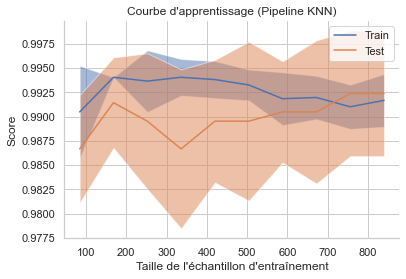

In [118]:
# Afficher la courbe d'apprentissage
visualize_learning_curve(
    clf_knn,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    verbose=2,
    title="Courbe d'apprentissage (Pipeline KNN)",
)

Le score d'apprentissage est plus élevé lorsqu'on utilise peu d'échantillons pour l'apprentissage et diminue lorsque le nombre d'échantillons augmente pour remonter ensuite, tandis que le score de test est très faible au début puis augmente lorsque l'on ajoute des échantillons.

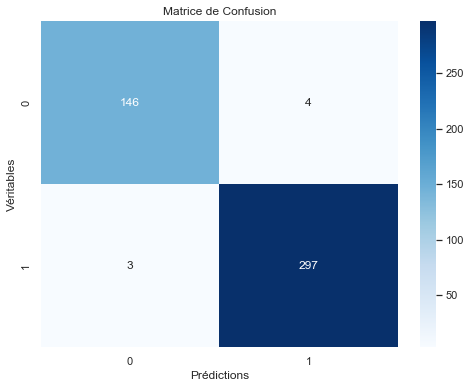

array([[146,   4],
       [  3, 297]], dtype=int64)

In [119]:
# Afficher la matrice de confusion
visualize_confusion_matrix(y_test, y_pred_knn, labels=[0, 1])

- TP : true positive, vrai positif : billets positifs prédits comme positifs. (quadrant inférieur droit) soit **297**

- FP : false positive, faux positif : billets négatifs prédits comme positifs de façon erronée. (quadrant supérieur droit) soit **4**

- TN : true negative, vrai négatif : billets négatifs prédits comme négatifs. (quadrant supérieur gauche) soit **146**

- FN : false negative, faux négatif : billets positifs prédits comme négatifs de façon erronée. (quadrant inférieur gauche) soit **3**

In [120]:
# Synthèse des metrics
print("=== Performances globales ===")
calculate_model_metrics(y_test, y_pred_knn)

=== Performances globales ===
| Metric    |    Value |
|-----------|----------|
| Accuracy  | 0.984444 |
| F1-score  | 0.988353 |
| Precision | 0.986711 |
| Recall    | 0.99     |
| Auc       | 0.981667 |


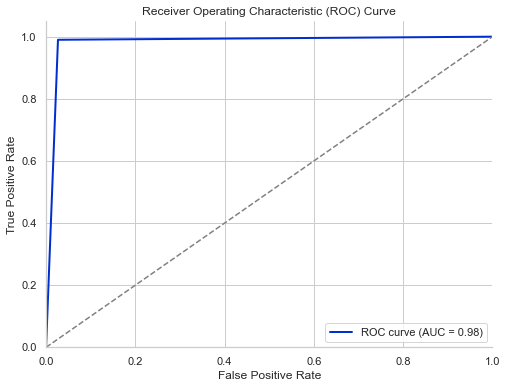

In [121]:
# Affciher la courbe de ROC et l'AUC
visualize_roc_curve(y_test, y_pred_knn)

L'AUC mesurée à 0,981 confirme la performance du modèle de classification. 

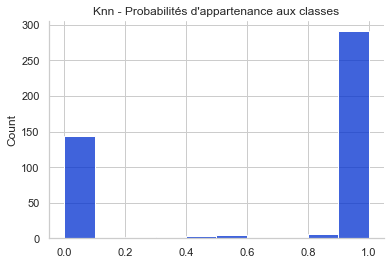

In [122]:
# Tracer l'histogramme des probabilités des prédictions.
y_proba_knn = clf_knn.predict_proba(X_test)[:, 1]

sns.histplot(y_proba_knn, color="#002FD0")
plt.title("Knn - Probabilités d'appartenance aux classes")
plt.show()

Le modèle est fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

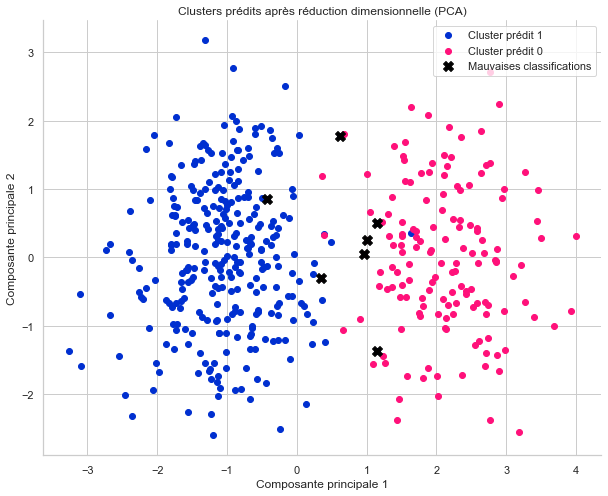

In [123]:
# Transformation des données de test
X_test_transformed = clf_knn[:-1].transform(X_test)


y_test_knn_pred = clf_knn.named_steps["knn"].predict(X_test_transformed)  # Clustering

pca = PCA(n_components=2)
X_test_knn_2d = pca.fit_transform(X_test_transformed)

# Créer un DataFrame pour faciliter la visualisation
df_viz = pd.DataFrame(
    {
        "x": X_test_knn_2d[:, 0],
        "y": X_test_knn_2d[:, 1],
        "true_class": y_test,
        "predicted_class": y_test_knn_pred,
    }
)


# Appeler la fonction de visualisation
colors = ["#002FD0", "#FF117A"]  # Ajouter autant de couleurs que de clusters
visualize_classification_results(df_viz, colors)

In [124]:
import joblib

# Sauvegarder le modèle KNN optimisé
joblib.dump(clf_knn.named_steps["knn"], "knn_model.pkl")
print("Modèle KNN sauvegardé avec succès sous 'knn_model.pkl'.")

# Sauvegarder le pipeline entier
joblib.dump(clf_knn, "knn_pipeline.pkl")
print("Pipeline KNN sauvegardé avec succès sous 'knn_pipeline.pkl'.")

Modèle KNN sauvegardé avec succès sous 'knn_model.pkl'.
Pipeline KNN sauvegardé avec succès sous 'knn_pipeline.pkl'.


<h3 style="margin: auto; padding: 20px; color: #000000; ">3.3 - Régression Logistique</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.3.1 - Description des données</h4>
</div>

In [125]:
# Afficher les dimensions dans chacun des jeux de données
print(f"Dimensions de X_train :", X_train.shape)
print(f"Dimensions de X_test :", X_test.shape)
print(f"Dimensions de y_train :", y_train.shape)
print(f"Dimensions de y_test :", y_test.shape)

Dimensions de X_train : (1050, 6)
Dimensions de X_test : (450, 6)
Dimensions de y_train : (1050,)
Dimensions de y_test : (450,)


In [126]:
# Afficher le nombre de données manquantes dans chacun des datasets
train_missing_before = X_train["margin_low"].isna().sum()
test_missing_before = X_test["margin_low"].isna().sum()

print(f"Nombre de données manquantes dans X_train :", train_missing_before)
print(f"Nombre de données manquantes dans X_test :", test_missing_before)

Nombre de données manquantes dans X_train : 24
Nombre de données manquantes dans X_test : 13


<h4 style="margin: auto; padding: 20px; color: #000000; ">3.3.2 - Construire le pipeline</h4>
</div>

In [127]:
# Liste des colonnes prédictrices
predictor_columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

# Créer le pipeline
clf_logit = Pipeline(
    [
        (
            "imputer",
            StaticLinearRegressionImputer(
                target_column="margin_low", predictor_columns=predictor_columns
            ),
        ),  # Remplacez "target_column_name" par la colonne cible
        ("scaler", StandardScaler()),
        ("logistic_regression", LogisticRegression(random_state=42)),
    ]
)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.3.3 - Entrainer le modèle sur les données Train</h4>
</div>

In [128]:
# Ajuster le pipeline sur les données d'entraînement
clf_logit.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(random_state=42))])

In [129]:
# Accéder à l'étape 'imputer' du pipeline
imputer_step = clf_logit.named_steps["imputer"]

# Extraire les informations pour le tableau
features = imputer_step.selected_features
coefficients = imputer_step.model.coef_
intercept = imputer_step.model.intercept_
r2_score_imputer = imputer_step.r2_score_
mae_score_imputer = imputer_step.mae_
mse_score_imputer = imputer_step.mse_
rmse_score_imputer = imputer_step.rmse_

# Créer un tableau pour les coefficients et les features
data = []
for feature, coef in zip(features, coefficients):
    data.append([feature, coef])


# Générer le tableau avec tabulate
table = tabulate(
    data,
    headers=["Variables", "Coef"],
    tablefmt="github",
    floatfmt=".4f",
)

# Données des résultats
imputer_metrics = [
    ["R²", round(r2_score_imputer, 4)],
    ["Intercept", round(imputer_step.model.intercept_, 4)],
    ["MAE", round(imputer_step.mae_, 4)],
    ["MSE", round(imputer_step.mse_, 4)],
    ["RMSE", round(imputer_step.rmse_, 4)],
]

# En-têtes des colonnes
headers = ["Metrics", "Score"]

# Affichage avec tabulate
table_2 = tabulate(imputer_metrics, headers=headers, tablefmt="github")

# Afficher le tableau
# Afficher les caractéristiques utilisées pour l'imputation
print("Variables utilisées pour l'imputation :", imputer_step.selected_features)
print("\n" * 1)
print("Résultats de la régression :\n")
print(table)
print("\n" * 1)
print("Performances du modèle :\n")
print(table_2)

Variables utilisées pour l'imputation : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


Résultats de la régression :

| Variables    |    Coef |
|--------------|---------|
| diagonal     |  0.0027 |
| height_left  | -0.0089 |
| height_right | -0.0118 |
| margin_up    | -0.0144 |
| length       |  0.0179 |


Performances du modèle :

| Metrics   |   Score |
|-----------|---------|
| R²        |  0.4573 |
| Intercept | -0.0511 |
| MAE       |  0.0175 |
| MSE       |  0.0005 |
| RMSE      |  0.0225 |


In [130]:
# Accéder à l'étape 'imputer'
imputer_step = clf_logit.named_steps["imputer"]

# Extraire les informations sur les valeurs manquantes
missing_before = imputer_step.missing_before_
missing_after = imputer_step.missing_after_

# Afficher les résultats
print(f"Valeurs manquantes avant transformation : {missing_before}")
print(f"Valeurs manquantes après transformation : {missing_after}")

Valeurs manquantes avant transformation : 24
Valeurs manquantes après transformation : 0


In [131]:
# Afficher les paramètres du pipeline
clf_logit.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('logistic_regression', LogisticRegression(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'logistic_regression': LogisticRegression(random_state=42),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'scal

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.3.4 - Réaliser les prédictions sur les données test</h4>
</div>

In [132]:
# Effectuer les prédictions sur le jeu de test
y_pred_logit = clf_logit.predict(X_test)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.3.5 - Evaluer les performances</h4>
</div>

In [133]:
# Afficher le rapport de classification
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      1.00      1.00       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



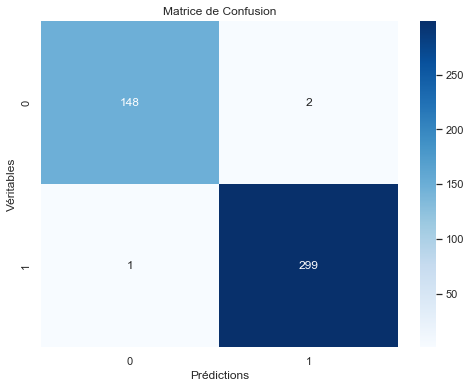

array([[148,   2],
       [  1, 299]], dtype=int64)

In [134]:
# Afficher la matrice de confusion
visualize_confusion_matrix(y_test, y_pred_logit, labels=[0, 1])

- TP : true positive, vrai positif : billets positifs prédits comme positifs. (quadrant inférieur droit) soit **299**

- FP : false positive, faux positif : billets négatifs prédits comme positifs de façon erronée. (quadrant supérieur droit) soit **2**

- TN : true negative, vrai négatif : billets négatifs prédits comme négatifs. (quadrant supérieur gauche) soit **148**

- FN : false negative, faux négatif : billets positifs prédits comme négatifs de façon erronée. (quadrant inférieur gauche) soit **1**

In [135]:
# Calcul du score sur les données d'entraînement et de test afin de distinguer un bon modèle d'un mauvais modèle.
logit_score_train = clf_logit.score(X_train, y_train)
logit_score_test = clf_logit.score(X_test, y_test)

# Afficher les scores
print(f"Score du modèle de données d'entrainement :{logit_score_train:.4f}")
print(f"Score du modèle de données test : {logit_score_test:.4f}")
print(f"Le modèle est bon et sait généraliser.")

Score du modèle de données d'entrainement :0.9924
Score du modèle de données test : 0.9933
Le modèle est bon et sait généraliser.


[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


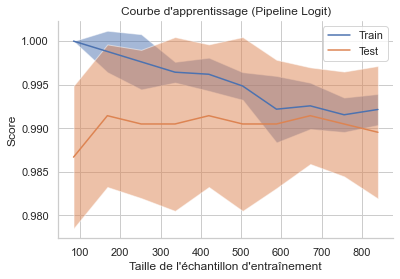

In [136]:
# Afficher la courbe d'apprentissage
visualize_learning_curve(
    clf_logit,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    verbose=2,
    title="Courbe d'apprentissage (Pipeline Logit)",
)

Le score d'apprentissage est très élevé lorsqu'on utilise peu d'échantillons pour l'apprentissage et diminue lorsque le nombre d'échantillons augmente, tandis que le score de test augmente lorsque le nombre d'échantillons est faible. Il pourrait ne pas être utile d'acquérir de nouvelles données pour entraîner le modèle puisque les performances de généralisation du modèle n'augmenteront plus.

Le 3ème graphique identifie, le point d'inflexion pour lequel le score de validation croisée n'augmente plus et seul le temps d'entraînement augmente.

In [137]:
# Synthèse des metrics
print("=== Performances globales ===")
calculate_model_metrics(y_test, y_pred_logit)

=== Performances globales ===
| Metric    |    Value |
|-----------|----------|
| Accuracy  | 0.993333 |
| F1-score  | 0.995008 |
| Precision | 0.993355 |
| Recall    | 0.996667 |
| Auc       | 0.991667 |


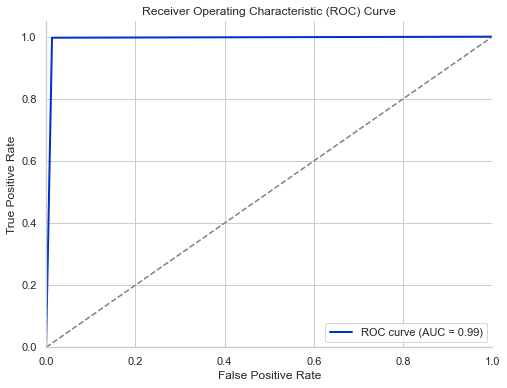

In [138]:
# Application de la fonction pour tracer la courbe ROC
visualize_roc_curve(y_test, y_pred_logit)

L'AUC mesurée à 0,991 confirme la performance du modèle de classification. 

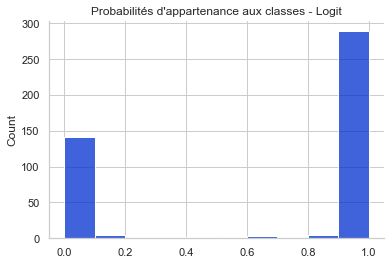

In [139]:
# Tracer l'histogramme des probabilités des prédictions.
y_proba_logit = clf_logit.predict_proba(X_test)[:, 1]

sns.histplot(y_proba_logit, color="#002FD0")
plt.title("Probabilités d'appartenance aux classes - Logit")
plt.show()

Le modèle est fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

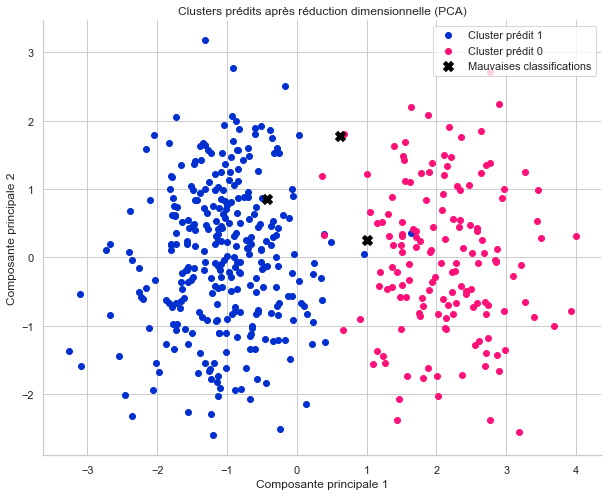

In [140]:
# Afficher les résultats sur les 2 premières composantes d'une ACP
# Transformation des données de test
X_test_transformed = clf_logit[:-1].transform(X_test)


y_test_reg_log_pred = clf_logit.named_steps["logistic_regression"].predict(
    X_test_transformed
)  # Clustering

pca = PCA(n_components=2)
X_test_reg_log_2d = pca.fit_transform(X_test_transformed)

# Créer un DataFrame pour faciliter la visualisation
df_viz = pd.DataFrame(
    {
        "x": X_test_reg_log_2d[:, 0],
        "y": X_test_reg_log_2d[:, 1],
        "true_class": y_test,
        "predicted_class": y_test_reg_log_pred,
    }
)

#  Appeler la fonction de visualisation
colors = ["#002FD0", "#FF117A"]  # Ajouter autant de couleurs que de clusters
visualize_classification_results(df_viz, colors)

In [141]:
import joblib

# Sauvegarder le modèle optimisé (TunedThresholdClassifierCV)
joblib.dump(clf_logit.named_steps["logistic_regression"], "logit_model.pkl")
print(
    "Modèle ode Régression <logistique sauvegardé avec succès sous 'logit_model.pkl'."
)

# Sauvegarder uniquement le pipeline d'origine si nécessaire
joblib.dump(clf_logit, "logit_pipeline.pkl")
print("Pipeline original sauvegardé avec succès sous 'logit_pipeline.pkl'.")

Modèle ode Régression <logistique sauvegardé avec succès sous 'logit_model.pkl'.
Pipeline original sauvegardé avec succès sous 'logit_pipeline.pkl'.


<h3 style="margin: auto; padding: 20px; color: #000000; ">3.4 - RandomForest</h3>
</div>

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.4.1 - Description des données</h4>
</div>

In [142]:
# Afficher les dimensions dans chacun des jeu de données
print(f"Dimensions de X_train_rf :", X_train.shape)
print(f"Dimensions de X_test_rf :", X_test.shape)
print(f"Dimensions de y_train_rf :", y_train.shape)
print(f"Dimensions de y_test_rf :", y_test.shape)

Dimensions de X_train_rf : (1050, 6)
Dimensions de X_test_rf : (450, 6)
Dimensions de y_train_rf : (1050,)
Dimensions de y_test_rf : (450,)


In [143]:
# Afficher le nombre de données manquantes dans chacun des datasets
train_missing_before = X_train["margin_low"].isna().sum()
test_missing_before = X_test["margin_low"].isna().sum()

print(f"Nombre de données manquantes dans X_train :", train_missing_before)
print(f"Nombre de données manquantes dans X_test :", test_missing_before)

Nombre de données manquantes dans X_train : 24
Nombre de données manquantes dans X_test : 13


<h4 style="margin: auto; padding: 20px; color: #000000; ">3.4.2 - Construire le pipeline</h4>
</div>

In [144]:
# Liste des colonnes prédictrices
predictor_columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

# Créer le pipeline
clf_rf = Pipeline(
    [
        (
            "imputer",
            StaticLinearRegressionImputer(
                target_column="margin_low", predictor_columns=predictor_columns
            ),
        ),  # Remplacez "target_column_name" par la colonne cible
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(random_state=42)),
    ]
)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.4.3 - Entrainer le modèle sur les données Train</h4>
</div>

In [145]:
# Modéliser un premier modèle
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

In [146]:
# Accéder à l'étape 'imputer'
imputer_step = clf_rf.named_steps["imputer"]


# Extraire les informations pour le tableau
features = imputer_step.selected_features
coefficients = imputer_step.model.coef_
intercept = imputer_step.model.intercept_
r2_score_imputer = imputer_step.r2_score_
mae_score_imputer = imputer_step.mae_
mse_score_imputer = imputer_step.mse_
rmse_score_imputer = imputer_step.rmse_

# Créer un tableau pour les coefficients et les features
data = []
for feature, coef in zip(features, coefficients):
    data.append([feature, coef])


# Générer le tableau avec tabulate
table = tabulate(
    data,
    headers=["Variables", "Coef"],
    tablefmt="github",
    floatfmt=".4f",
)

# Données des résultats
imputer_metrics = [
    ["R²", round(r2_score_imputer, 4)],
    ["Intercept", round(imputer_step.model.intercept_, 4)],
    ["MAE", round(imputer_step.mae_, 4)],
    ["MSE", round(imputer_step.mse_, 4)],
    ["RMSE", round(imputer_step.rmse_, 4)],
]

# En-têtes des colonnes
headers = ["Metrics", "Score"]

# Affichage avec tabulate
table_2 = tabulate(imputer_metrics, headers=headers, tablefmt="github")

# Afficher le tableau
# Afficher les caractéristiques utilisées pour l'imputation
print("Variables utilisées pour l'imputation :", imputer_step.selected_features)
print("\n" * 1)
print("Résultats de la régression :\n")
print(table)
print("\n" * 1)
print("Performances du modèle :\n")
print(table_2)

Variables utilisées pour l'imputation : ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


Résultats de la régression :

| Variables    |    Coef |
|--------------|---------|
| diagonal     |  0.0027 |
| height_left  | -0.0089 |
| height_right | -0.0118 |
| margin_up    | -0.0144 |
| length       |  0.0179 |


Performances du modèle :

| Metrics   |   Score |
|-----------|---------|
| R²        |  0.4573 |
| Intercept | -0.0511 |
| MAE       |  0.0175 |
| MSE       |  0.0005 |
| RMSE      |  0.0225 |


In [147]:
# Accéder à l'étape 'imputer'
imputer_step = clf_rf.named_steps["imputer"]


# Extraire les informations sur les valeurs manquantes
missing_before = imputer_step.missing_before_
missing_after = imputer_step.missing_after_

# Afficher les résultats
print(f"Valeurs manquantes avant transformation : {missing_before}")
print(f"Valeurs manquantes après transformation : {missing_after}")

Valeurs manquantes avant transformation : 24
Valeurs manquantes après transformation : 0


In [148]:
# Afficher les paramètres du pipeline
clf_rf.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'rf': RandomForestClassifier(random_state=42),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'scaler__copy': True,
 'scaler_

In [149]:
# Optimiser les hyperparamètres
# Espace de recherche des hyperparamètres
param_distributions = {
    "n_estimators": [100, 200, 300, 400, 500],  # Nombre d'arbres
    "max_features": ["sqrt", "log2", None],  # Nombre de features pour diviser
    "max_depth": [None, 10, 20, 30, 40, 50],  # Profondeur maximale des arbres
    "min_samples_split": [
        2,
        5,
        10,
    ],  # Nombre minimum d'échantillons pour diviser un nœud
    "min_samples_leaf": [1, 2, 4],  # Nombre minimum d'échantillons par feuille
    "bootstrap": [True, False],  # Utilisation du bootstrap
}

In [150]:
# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf_rf.named_steps["rf"],
    param_distributions=param_distributions,
    n_iter=50,  # Nombre d'itérations aléatoires
    scoring="accuracy",  # Métrique d'évaluation
    cv=5,  # Validation croisée avec 5 folds
    verbose=2,  # Niveau de verbosité
    random_state=42,
    n_jobs=-1,  # Utilisation de tous les cœurs disponibles
)

In [151]:
# Recherche des meilleurs hyperparamètres
random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le score correspondant
print("Meilleurs hyperparamètres :", random_search.best_params_)
print("Meilleur score (validation) :", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs hyperparamètres : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Meilleur score (validation) : 0.9933333333333334


In [152]:
# Récupérer les meilleurs paramètres et les ajuster pour le pipeline
best_params = {f"rf__{key}": value for key, value in random_search.best_params_.items()}

# Mettre à jour le pipeline avec les meilleurs paramètres
clf_rf.set_params(**best_params)

# Réentraîner le pipeline optimisé sur l'ensemble des données d'entraînement
clf_rf.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 StaticLinearRegressionImputer(predictor_columns=['diagonal',
                                                                  'height_left',
                                                                  'height_right',
                                                                  'margin_up',
                                                                  'length'],
                                               target_column='margin_low')),
                ('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [153]:
# Afficher les paramètres du pipeline mis à jour
clf_rf.get_params()

{'memory': None,
 'steps': [('imputer',
   StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                    'height_right', 'margin_up',
                                                    'length'],
                                 target_column='margin_low')),
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(max_depth=10, random_state=42))],
 'transform_input': None,
 'verbose': False,
 'imputer': StaticLinearRegressionImputer(predictor_columns=['diagonal', 'height_left',
                                                  'height_right', 'margin_up',
                                                  'length'],
                               target_column='margin_low'),
 'scaler': StandardScaler(),
 'rf': RandomForestClassifier(max_depth=10, random_state=42),
 'imputer__predictor_columns': ['diagonal',
  'height_left',
  'height_right',
  'margin_up',
  'length'],
 'imputer__target_column': 'margin_low',
 'sc

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.4.4 - Réaliser les prédictions sur les données test</h4>
</div>

In [154]:
# Réaliser une prédiction sur les données test
y_pred_rf = clf_rf.predict(X_test)

<h4 style="margin: auto; padding: 20px; color: #000000; ">3.4.5 - Evaluer les performances</h4>
</div>

In [155]:
# Afficher le rapport
print("=== Performances globales ===")
print(classification_report(y_test, y_pred_rf))

=== Performances globales ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       150
           1       0.99      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.99      0.99      0.99       450



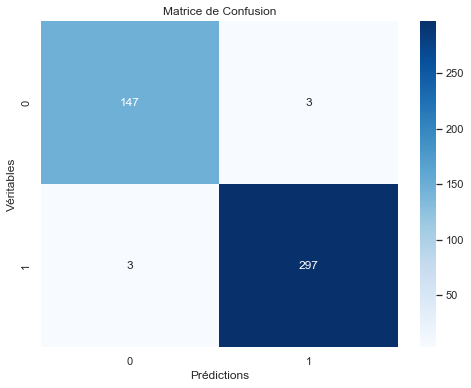

array([[147,   3],
       [  3, 297]], dtype=int64)

In [156]:
# Afficher la matrice de confusion
visualize_confusion_matrix(y_test, y_pred_rf, labels=[0, 1])

- TP : true positive, vrai positif : billets positifs prédits comme positifs. (quadrant inférieur droit) soit **297**

- FP : false positive, faux positif : billets négatifs prédits comme positifs de façon erronée. (quadrant supérieur droit) soit **3**

- TN : true negative, vrai négatif : billets négatifs prédits comme négatifs. (quadrant supérieur gauche) soit **147**

- FN : false negative, faux négatif : billets positifs prédits comme négatifs de façon erronée. (quadrant inférieur gauche) soit **3**

In [157]:
# Calcul du score sur les données d'entraînement et de test afin de distinguer un bon modèle d'un mauvais modèle.
rf_score_train = clf_rf.score(X_train, y_train)
rf_score_test = clf_rf.score(X_test, y_test)

# Afficher les scores
print(f"Score du modèle de données d'entrainement :{rf_score_train:.4f}")
print(f"Score du modèle de données test : {rf_score_test:.4f}")
print(f"Le modèle est bon et sait généraliser.")

Score du modèle de données d'entrainement :1.0000
Score du modèle de données test : 0.9867
Le modèle est bon et sait généraliser.


[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.6s finished


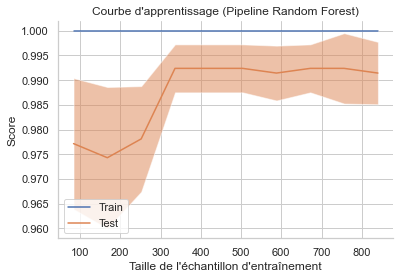

In [158]:
# Afficher la courbe d'apprentissage
visualize_learning_curve(
    clf_rf,
    X_train,
    y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    verbose=2,
    title="Courbe d'apprentissage (Pipeline Random Forest)",
)

Le score d'apprentissage est très élevé voire parfait quelque soit le nombre d'échantillons, tandis que le score de test est plus faible au début puis augmente lorsque l'on ajoute des échantillons pour baisser lorsque le nombre d'échantillons devient trop grand. Ainsi, il pourrait ne pas être utile d'acquérir de nouvelles données pour entraîner le modèle.

Le dernier graphique identifie le point d'inflexion pour lequel le score de validation croisée n'augmente plus et seul le temps d'entraînement augmente.

In [159]:
# Synthèse des metrics
print("=== Performances globales ===")
calculate_model_metrics(y_test, y_pred_rf)

=== Performances globales ===
| Metric    |    Value |
|-----------|----------|
| Accuracy  | 0.986667 |
| F1-score  | 0.99     |
| Precision | 0.99     |
| Recall    | 0.99     |
| Auc       | 0.985    |


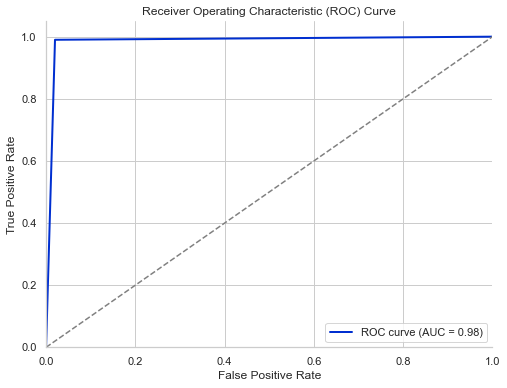

In [160]:
# Afficher la courbe de ROC et l'AUC
visualize_roc_curve(y_test, y_pred_rf)

L'AUC mesurée à 0,985 confirme la performance du modèle de classification. 

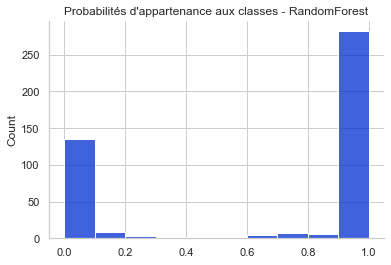

In [161]:
# Tracer l'histogramme des probabilités des prédictions.
y_proba_rf = clf_rf.predict_proba(X_test)[:, 1]

sns.histplot(y_proba_rf, color="#002FD0")
plt.title("Probabilités d'appartenance aux classes - RandomForest")
plt.show()

Le modèle est fiable au niveau de ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

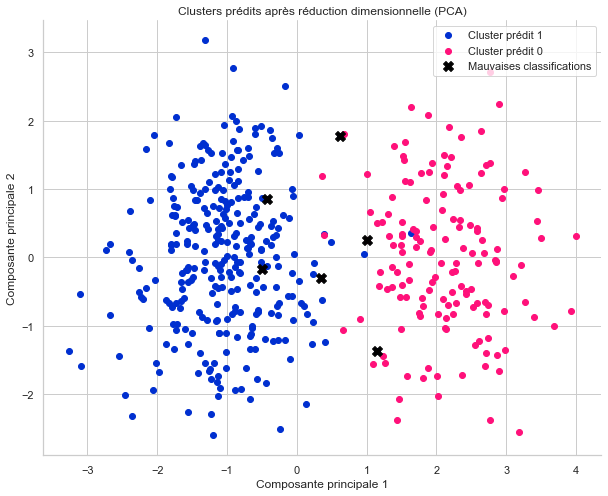

In [162]:
# Afficher les prédictions sur les 2 premiers axes d'une ACP

# Transformation des données de test
X_test_transformed = clf_rf[:-1].transform(X_test)

y_test_rf_pred = clf_rf.named_steps["rf"].predict(X_test_transformed)  # Clustering


# Extraire les 2 premières composantes
pca = PCA(n_components=2)
X_test_rf_2d = pca.fit_transform(X_test_transformed)

# Créer un DataFrame pour faciliter la visualisation
df_viz = pd.DataFrame(
    {
        "x": X_test_rf_2d[:, 0],
        "y": X_test_rf_2d[:, 1],
        "true_class": y_test,
        "predicted_class": y_test_rf_pred,
    }
)


# Étape 5 : Appeler la fonction de visualisation
colors = ["#002FD0", "#FF117A"]  # Ajouter autant de couleurs que de clusters
visualize_classification_results(df_viz, colors)

In [163]:
import joblib

# Sauvegarder le modèle rf optimisé
joblib.dump(clf_rf.named_steps["rf"], "rf_model.pkl")
print("Modèle rf sauvegardé avec succès sous 'rf_model.pkl'.")


# Sauvegarder le pipeline optimisé
joblib.dump(clf_rf, "optimized_rf_pipeline.pkl")
print("Pipeline sauvegardé avec succès sous 'optimized_rf_pipeline.pkl'.")

Modèle rf sauvegardé avec succès sous 'rf_model.pkl'.
Pipeline sauvegardé avec succès sous 'optimized_rf_pipeline.pkl'.


<h2 style="margin: auto; padding: 20px; color:#000000; ">Etape 4 - Conclusion</h2>
</div>

c:\Users\jerem\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1411: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jerem\AppData\Local\Temp\ipykernel_24296\3578129248.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(scatter, ax=axes[-1], orientation="horizontal", fraction=0.05, pad=0.1)


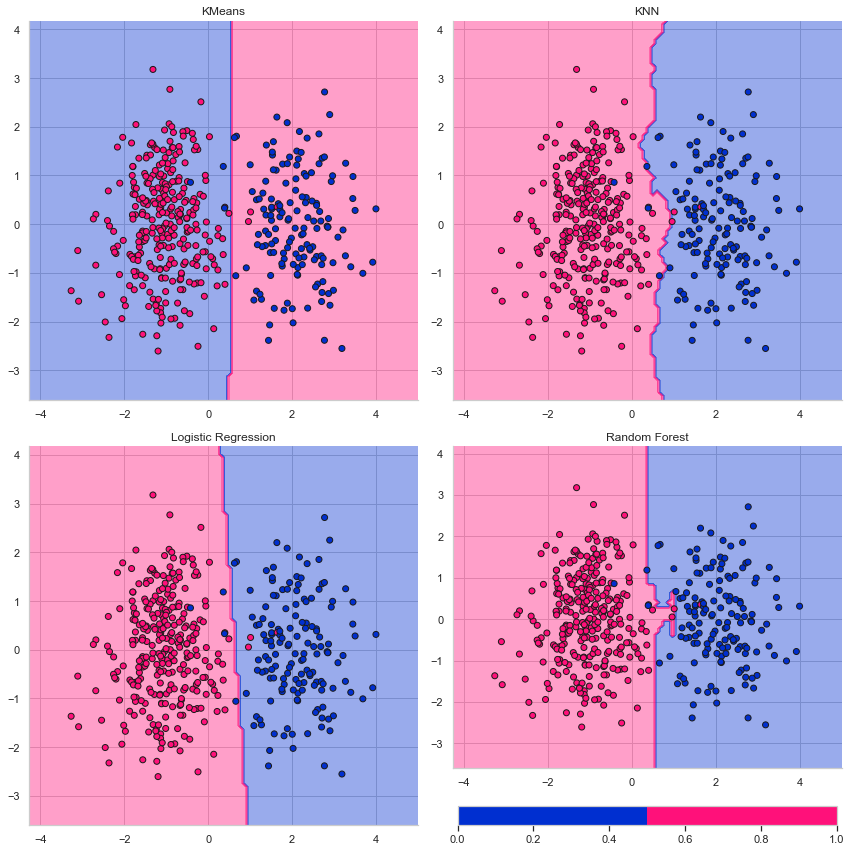

In [164]:
# Palette de couleurs personnalisée
colors = ["#002fd0", "#ff117a"]
cmap = ListedColormap(colors)

# Transformez les données avec les étapes du pipeline avant le modèle
X_test_transformed = clf_logit[:-1].transform(X_test)

# Réduction de dimensions avec PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_transformed)

# Mise en place des subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Ajusté la taille pour plus de clarté
axes = axes.flatten()  # Aplatir la matrice des axes en liste

# Modèles à afficher
models = [
    ("KMeans", clf_kmeans.named_steps["kmeans"]),
    ("KNN", clf_knn.named_steps["knn"]),
    ("Logistic Regression", clf_logit.named_steps["logistic_regression"]),
    ("Random Forest", clf_rf.named_steps["rf"]),
]

# Affichage des limites de décision pour chaque modèle
for ax, (name, model) in zip(axes, models):
    # Refit du modèle sur les données projetées en 2D
    model.fit(X_test_2d, y_test)

    # Affichage des limites de décision
    DecisionBoundaryDisplay.from_estimator(
        model, X_test_2d, ax=ax, response_method="predict", alpha=0.4, cmap=cmap
    )

    # Scatter plot des points avec la palette de couleurs personnalisée
    scatter = ax.scatter(
        X_test_2d[:, 0],
        X_test_2d[:, 1],
        c=y_test,
        edgecolor="k",
        cmap=cmap,  # Appliquer la palette personnalisée
    )

    ax.set_title(name)

# Ajouter une légende commune (liée aux couleurs des classes)
fig.colorbar(scatter, ax=axes[-1], orientation="horizontal", fraction=0.05, pad=0.1)
plt.tight_layout()
plt.show()

In [165]:
# Résultats Kmeans
kmeans_accuracy = accuracy_score(y_test, y_pred_kmeans)
kmeans_f1 = f1_score(y_test, y_pred_kmeans)  # ou 'binary', 'macro', etc.
kmeans_precision = precision_score(y_test, y_pred_kmeans)  # idem ici
kmeans_recall = recall_score(y_test, y_pred_kmeans)  # idem ici
kmeans_auc = roc_auc_score(y_test, y_pred_kmeans)


# Résultats Knn
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)  # ou 'binary', 'macro', etc.
knn_precision = precision_score(y_test, y_pred_knn)  # idem ici
knn_recall = recall_score(y_test, y_pred_knn)  # idem ici
knn_auc = roc_auc_score(y_test, y_pred_knn)


# Résultats Régression Logistique
logit_accuracy = accuracy_score(y_test, y_pred_logit)
logit_f1 = f1_score(y_test, y_pred_logit)  # ou 'binary', 'macro', etc.
logit_precision = precision_score(y_test, y_pred_logit)  # idem ici
logit_recall = recall_score(y_test, y_pred_logit)  # idem ici
logit_auc = roc_auc_score(y_test, y_pred_logit)


# Résultats Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)  # ou 'binary', 'macro', etc.
rf_precision = precision_score(y_test, y_pred_rf)  # idem ici
rf_recall = recall_score(y_test, y_pred_rf)  # idem ici
rf_auc = roc_auc_score(y_test, y_pred_rf)

In [166]:
data = {
    "Modèle": ["Kmeans", "Knn", "Régression Logistique", "Random Forest"],
    "Accuracy": [kmeans_accuracy, knn_accuracy, logit_accuracy, rf_accuracy],
    "F1-Score": [kmeans_f1, knn_f1, logit_f1, rf_f1],
    "Precision": [kmeans_precision, knn_precision, logit_precision, rf_precision],
    "Recall": [kmeans_recall, knn_recall, logit_recall, rf_recall],
    "Auc": [kmeans_auc, knn_auc, logit_auc, rf_auc],
}

In [167]:
# Afficher la synthèse des résultats pour chacun des algorithmes utilisés
synthese_metrics = pd.DataFrame(data)
synthese_metrics

,Modèle,Accuracy,F1-Score,Precision,Recall,Auc
0,Kmeans,0.984444,0.988353,0.986711,0.990000,0.981667
1,Knn,0.984444,0.988353,0.986711,0.990000,0.981667
2,Régression Logistique,0.993333,0.995008,0.993355,0.996667,0.991667
3,Random Forest,0.986667,0.990000,0.990000,0.990000,0.985000


Evolution des modèles prédictifs en examinant leur coût de calcul 

[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[learning_curve] Training set sizes: [ 84 168 252 336 420 504 588 672 756 840]


[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


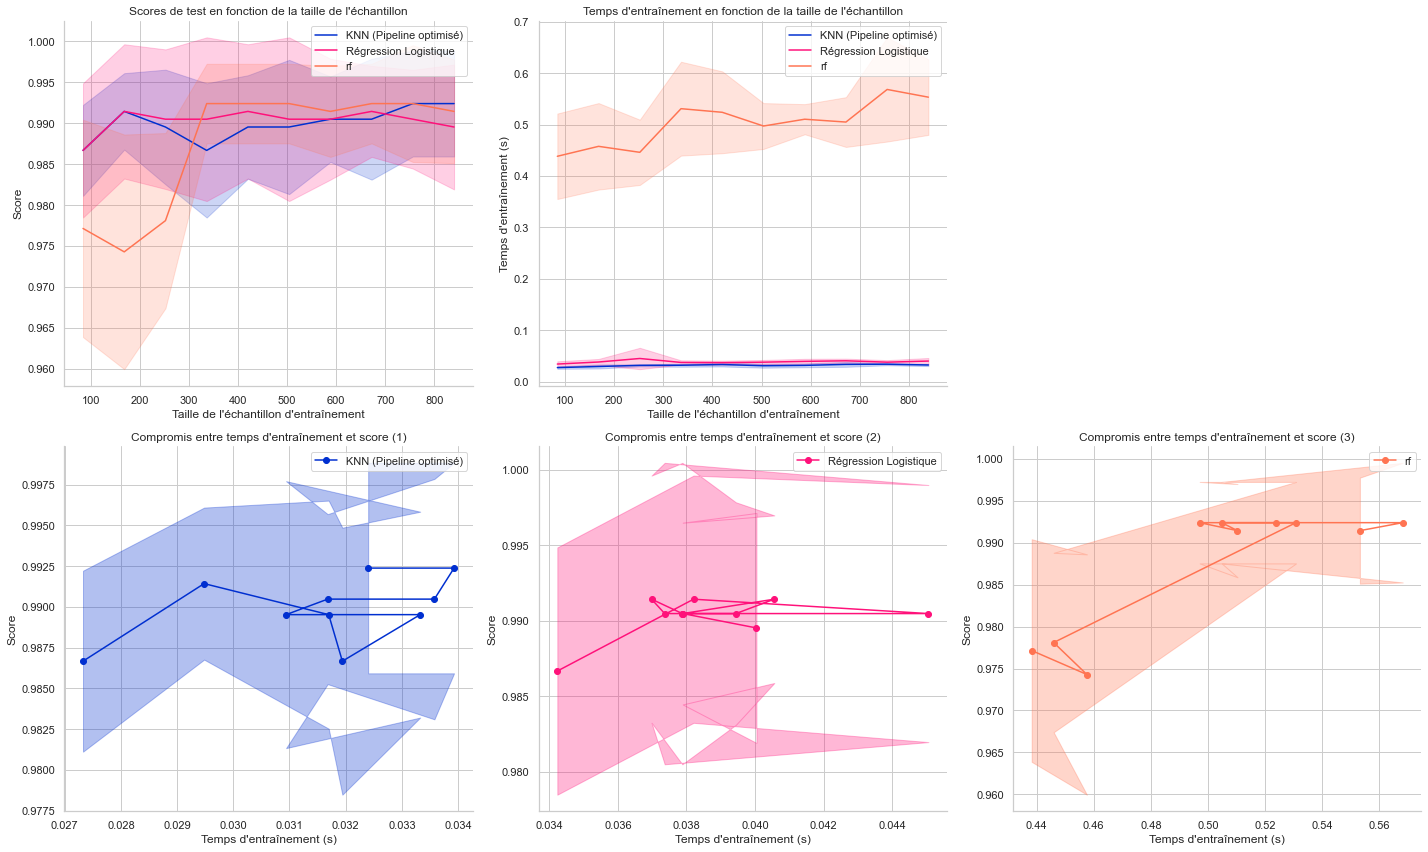

In [168]:
# Dictionnaire des modèles
models = {
    "KNN (Pipeline optimisé)": clf_knn,
    "Régression Logistique": clf_logit,
    "rf": clf_rf,
}

check_models_scalability(
    models=models,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_times=True,
    random_state=42,
)

Comparer visuellement les performances statistiques sur plusieurs seuils à l'aide des courbes ROC et DET.

- Les courbes ROC présentent le taux de vrais positifs (TPR) sur l'axe Y et le taux de faux positifs (FPR) sur l'axe X. Cela signifie que le coin supérieur gauche du graphique est le point « idéal » - un FPR de zéro et un TPR de un.

- Les courbes DET sont une variante des courbes ROC où le taux de faux négatifs (FNR) est tracé sur l'axe des Y au lieu du TPR. Dans ce cas, l'origine (coin inférieur gauche) est le point « idéal ».

In [169]:
classifiers = {
    "Knn": clf_knn,
    "Régression Logistique": clf_logit,
    "Random Forest": clf_rf,
}

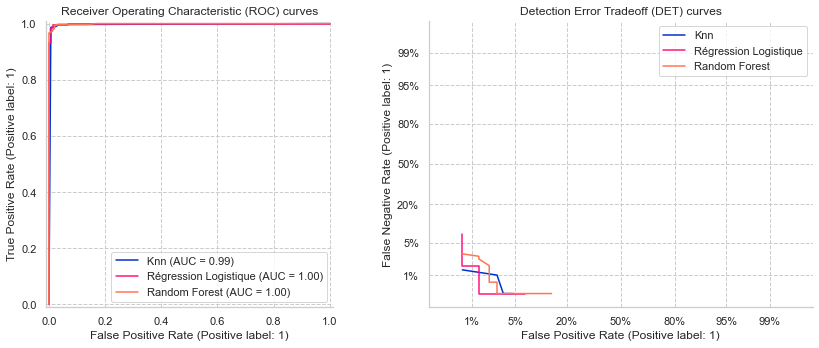

In [170]:
# Définir la palette de couleurs
colors = ["#002fd0", "#ff117a", "#ff7452"]

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 5))

# Boucle sur les classificateurs avec gestion des couleurs
for (name, clf), color in zip(classifiers.items(), colors):
    clf.fit(X_train, y_train)

    # Tracer les courbes ROC et DET avec les couleurs spécifiées
    RocCurveDisplay.from_estimator(
        clf, X_test, y_test, ax=ax_roc, name=name, color=color
    )
    DetCurveDisplay.from_estimator(
        clf, X_test, y_test, ax=ax_det, name=name, color=color
    )

# Configurer les titres et grilles des graphiques
ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

# Ajouter une légende globale
plt.legend()
plt.tight_layout()
plt.show()

In [171]:
# Initialiser des listes pour stocker les données
roc_data = []
det_data = []

# Boucle sur les classifieurs
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    # Calcul des courbes ROC
    fpr, tpr, roc_thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_data.append(
        pd.DataFrame(
            {
                "Classifier": name,
                "FPR": fpr,
                "TPR": tpr,
                "Threshold": roc_thresholds,
            }
        )
    )

    # Calcul des courbes DET
    fpr_det, fnr_det, det_thresholds = det_curve(
        y_test, clf.predict_proba(X_test)[:, 1]
    )
    det_data.append(
        pd.DataFrame(
            {
                "Classifier": name,
                "FPR": fpr_det,
                "FNR": fnr_det,
                "Threshold": det_thresholds,
            }
        )
    )

# Concaténer les résultats en DataFrame
df_roc = pd.concat(roc_data, ignore_index=True)
df_det = pd.concat(det_data, ignore_index=True)

# Afficher les résultats
df_det.head(60)

,Classifier,FPR,FNR,Threshold
0,Knn,1.000000,0.000000,0.000000
1,Knn,0.046667,0.003333,0.200000
2,Knn,0.033333,0.003333,0.400000
3,Knn,0.026667,0.010000,0.600000
4,Knn,0.006667,0.013333,0.800000
5,Régression Logistique,0.066667,0.000000,0.080069
6,Régression Logistique,0.066667,0.003333,0.090085
7,Régression Logistique,0.060000,0.003333,0.135798
8,Régression Logistique,0.053333,0.003333,0.136132
9,Régression Logistique,0.046667,0.003333,0.146474


In [172]:
# Transformation des données avec le pipeline
X_test_transformed = clf_logit[:-1].transform(X_test)  # Exclure le modèle final

# Calcul des probabilités au seuil de 0.5
threshold = 0.50
y_pred_proba = clf_logit[-1].predict_proba(X_test_transformed)[:, 1]
y_pred_custom = (y_pred_proba >= threshold).astype(int)

# Matrice de confusion et FNR
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

print("False Positive Rate (FPR) : ", fpr)
print("False Negative Rate (FNR) :", fnr)

False Positive Rate (FPR) :  0.013333333333333334
False Negative Rate (FNR) : 0.0033333333333333335


**Choix d’un modèle et d’un seuil optimal**

**Critères pour un modèle optimal dans la détection de faux billets :**
- FPR faible :  ne pas classer par erreur des vrais billets comme des faux. (détecter les vrais)
- FNR faible : objectif principal est de maximiser la détection des faux. (détecter les faux)

**Conclusions :**
- **La régression logistique et Random Forest** semblent offrir des compromis intéressants autour de seuils modérés (0.4-0.6) avec des FPR et FNR faibles.
- Le **KNN** semble robuste pour de faibles seuils, mais pourrait ne pas s’adapter aussi bien que les autres modèles si les données deviennent plus complexes.

En définitive, le **modèle Logit (régression Logistique) est retenu**.

- Le FNR extrêmement bas (0,33%) signifie que seulement 1 faux billets sur 300 n'est pas détecté.
- Le FPR de 1,33% est acceptable si des processus de vérification secondaire (comme l'examen manuel) peuvent gérer ces cas.

In [173]:
# Transformer les données avec le pipeline (sans ajuster le modèle)
X_test_transformed = clf_logit[:-1].transform(X_test)

# Obtenir les probabilités de prédiction pour chaque classe
y_proba = clf_logit.named_steps["logistic_regression"].predict_proba(
    X_test_transformed
)[
    :, 1
]  # Probabilité de la classe positive

# Appliquer un seuil personnalisé
threshold = 0.552901
y_pred_custom = (y_proba >= threshold).astype(int)

# Recalculer les métriques
print("Confusion Matrix (seuil = 0.55) :\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report :\n", classification_report(y_test, y_pred_custom))

# Calcul de l'AUC avec le seuil personnalisé
auc_custom = roc_auc_score(y_test, y_proba)
print(f"\nAUC : {auc_custom:.3f}")

# Vérifier le FPR et le FNR
cm = confusion_matrix(y_test, y_pred_custom)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate
print(f"FPR: {fpr:.5f}")
print(f"FNR: {fnr:.5f}")

Confusion Matrix (seuil = 0.55) :
 [[148   2]
 [  1 299]]

Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      1.00      1.00       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450


AUC : 0.999
FPR: 0.01333
FNR: 0.00333
